# AgroInspector
### Deep Learning-based Crop Legality and Disease Detection

**Team Members:**
- Yeswanth Chitturi 
- Kush Shah 
- Neeraj Kumar Gummadi  

## Introduction

**AgroInspector** is a deep learning-powered pipeline designed to assist in agricultural image analysis. It can:

1. **Detect illegal crops**,
2. **Identify the specific type** of illegal crop (if applicable),
3. **Determine the health status** of a crop (Healthy or Diseased),
4. **Classify the disease** if the crop is diseased,
5. **Identify the crop type** if it is both legal and healthy.

This multi-stage system is built using custom CNN architectures and trained on curated image datasets. It offers a scalable solution for crop monitoring and regulatory inspection.


## Importing all required Libraries.

In [ ]:
import os
import time
import torch
import random
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import torch.nn as nn
from glob import glob
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import defaultdict
from torchvision.utils import save_image
from sklearn.metrics import accuracy_score
from torchvision import transforms, datasets
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from sklearn.utils.multiclass import unique_labels
from torch.utils.data import DataLoader, random_split
from torchvision.datasets.folder import default_loader
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="PIL.Image")


## Dataset Overview

### Legal & Illegal Dataset

In [2]:
dataset_path = "/user/ychittur/DL/Final Project/Dataset/Illegal_Binary"  
dataset = ImageFolder(dataset_path)

In [ ]:
class_counts = defaultdict(int)
widths = defaultdict(list)
heights = defaultdict(list)
sample_images = {}

for img_path, label in dataset.samples:
    class_name = dataset.classes[label]
    if class_name not in sample_images:
        sample_images[class_name] = img_path
    image = Image.open(img_path)
    image = image.convert("RGB")
    w, h = image.size
    class_counts[class_name] += 1
    widths[class_name].append(w)
    heights[class_name].append(h)

records = []
for cls in class_counts:
    records.append({
        "Class": cls,
        "Image Count": class_counts[cls],
        "Avg Width": sum(widths[cls]) // len(widths[cls]),
        "Avg Height": sum(heights[cls]) // len(heights[cls]),
        "Sample Image Path": sample_images[cls]
    })

df = pd.DataFrame(records).sort_values("Image Count", ascending=False)

#### Data Satistics

In [4]:
print(f" Total Images      : {df['Image Count'].sum()}")
print(f" Total Classes     : {len(df)}")
print(f" Max Images/Class  : {df['Image Count'].max()} ({df.iloc[0]['Class']})")
print(f" Min Images/Class  : {df['Image Count'].min()} ({df.iloc[-1]['Class']})")
print(f" Average Img Count : {int(df['Image Count'].mean())}")
print(f" Avg Image Width   : {int(df['Avg Width'].mean())}")
print(f" Avg Image Height  : {int(df['Avg Height'].mean())}")

 Total Images      : 10069
 Total Classes     : 2
 Max Images/Class  : 5071 (illegal)
 Min Images/Class  : 4998 (Legal)
 Average Img Count : 5034
 Avg Image Width   : 271
 Avg Image Height  : 284


#### No of Images per class

/scratch/19524329/ipykernel_3229548/2202124460.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class", y="Image Count", data=df, palette="Set2")


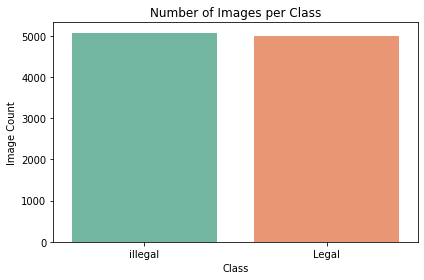

In [5]:
plt.figure(figsize=(6, 4))
sns.barplot(x="Class", y="Image Count", data=df, palette="Set2")
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()

#### Legal vs Illegal class distribution

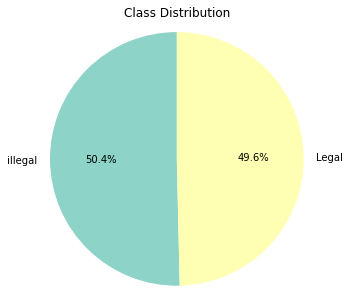

In [6]:
plt.figure(figsize=(5, 5))
plt.pie(df["Image Count"], labels=df["Class"], autopct="%1.1f%%", startangle=90, colors=sns.color_palette("Set3"))
plt.title("Class Distribution")
plt.axis("equal")
plt.show()

#### Avg Image Height vs Width

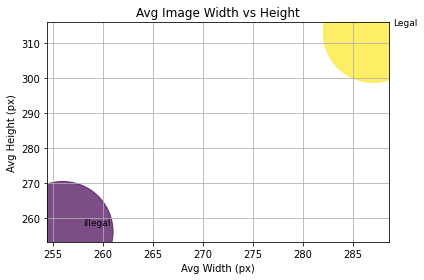

In [7]:
plt.figure(figsize=(6, 4))
plt.scatter(df["Avg Width"], df["Avg Height"], s=df["Image Count"]*2, c=range(len(df)), cmap="viridis", alpha=0.7)
for i, row in df.iterrows():
    plt.text(row["Avg Width"] + 2, row["Avg Height"] + 2, row["Class"], fontsize=9)
plt.title("Avg Image Width vs Height")
plt.xlabel("Avg Width (px)")
plt.ylabel("Avg Height (px)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Sample Images

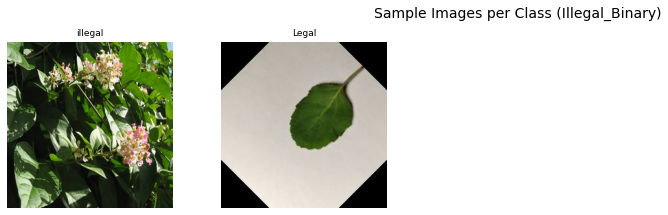

In [8]:
def show_class_samples(df):
    num_classes = len(df)
    cols = 5
    rows = (num_classes + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))

    for i, row in enumerate(df.itertuples()):
        img = Image.open(row._5).convert("RGB")
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(row.Class, fontsize=9)
        plt.axis("off")

    plt.suptitle("Sample Images per Class (Illegal_Binary)", fontsize=14)
    plt.tight_layout()
    plt.show()

show_class_samples(df)

### Illegal Crops Dataset

In [9]:
dataset_path = "/user/ychittur/DL/Final Project/Dataset/illegal"
dataset = ImageFolder(dataset_path)

In [10]:
class_counts = defaultdict(int)
widths = defaultdict(list)
heights = defaultdict(list)
sample_images = {} 

for img_path, label in dataset.samples:
    class_name = dataset.classes[label]
    if class_name not in sample_images:
        sample_images[class_name] = img_path  
    image = Image.open(img_path)
    if image.mode == 'P':
        image = image.convert("RGBA")
    else:
        image = image.convert("RGB")
    w, h = image.size
    class_counts[class_name] += 1
    widths[class_name].append(w)
    heights[class_name].append(h)

records = []
for cls in class_counts:
    records.append({
        "Class": cls,
        "Image Count": class_counts[cls],
        "Avg Width": sum(widths[cls]) // len(widths[cls]),
        "Avg Height": sum(heights[cls]) // len(heights[cls]),
        "Sample Image Path": sample_images[cls]
    })

df = pd.DataFrame(records).sort_values("Image Count", ascending=False)

#### Data Statistics

In [11]:
print("\n DataFrame Info:\n")
print(df.info())


 DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 1 to 9
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Class              10 non-null     object
 1   Image Count        10 non-null     int64 
 2   Avg Width          10 non-null     int64 
 3   Avg Height         10 non-null     int64 
 4   Sample Image Path  10 non-null     object
dtypes: int64(3), object(2)
memory usage: 480.0+ bytes
None


In [12]:
print("\nDataset Summary")
print(f"Total Images      : {df['Image Count'].sum()}")
print(f"Total Classes     : {len(df)}")
print(f"Max Images/Class  : {df['Image Count'].max()} ({df.iloc[0]['Class']})")
print(f"Min Images/Class  : {df['Image Count'].min()} ({df.iloc[-1]['Class']})")
print(f"Average Img Count : {int(df['Image Count'].mean())}")
print(f"Avg Image Width   : {int(df['Avg Width'].mean())}")
print(f"Avg Image Height  : {int(df['Avg Height'].mean())}")


Dataset Summary
Total Images      : 5071
Total Classes     : 10
Max Images/Class  : 525 (Cannabis)
Min Images/Class  : 497 (Salvia_divinorum)
Average Img Count : 507
Avg Image Width   : 256
Avg Image Height  : 256


#### Sample Images

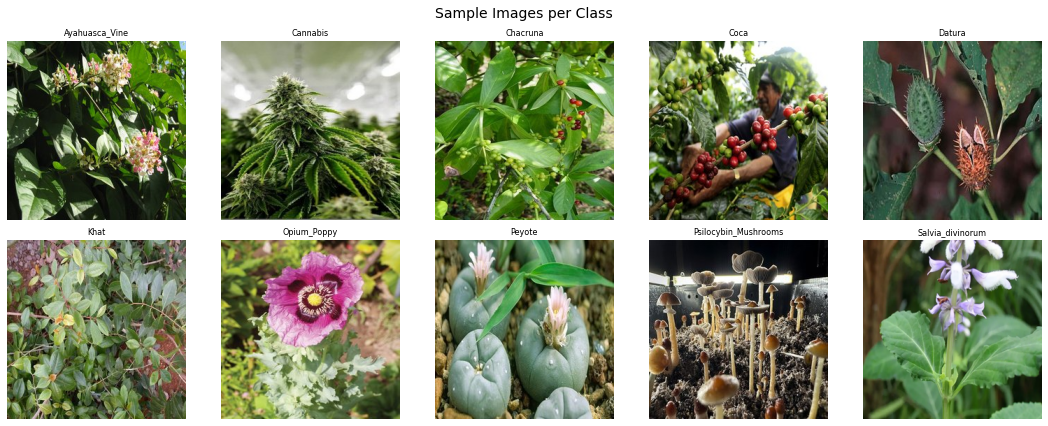

In [13]:
def show_class_samples(df):
    num_classes = len(df)
    cols = 5
    rows = (num_classes + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))

    for i, row in df.iterrows():
        img = Image.open(row["Sample Image Path"])
        if img.mode == 'P':
            img = img.convert("RGBA")
        else:
            img = img.convert("RGB")
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(row["Class"], fontsize=8)
        plt.axis("off")

    plt.suptitle("Sample Images per Class", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

show_class_samples(df)

#### Images per class

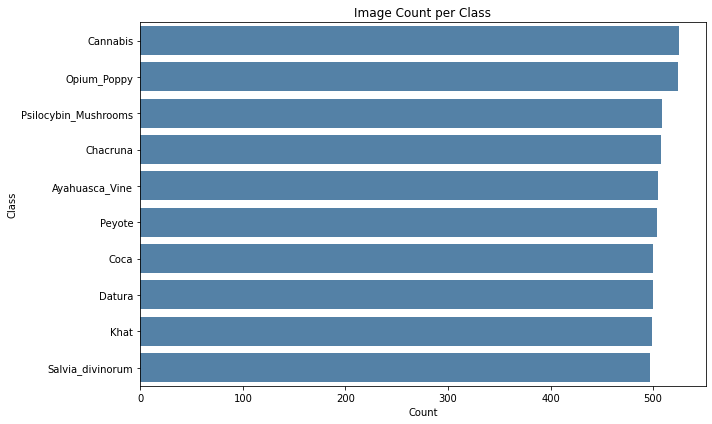

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, y="Class", x="Image Count", color='steelblue')
plt.title("Image Count per Class")
plt.xlabel("Count")
plt.ylabel("Class")
plt.tight_layout()
plt.show()

#### Class Distribution

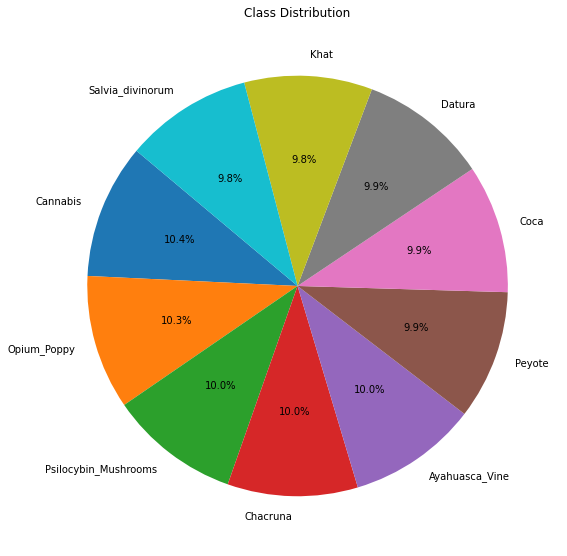

In [15]:
plt.figure(figsize=(8, 8))
plt.pie(df["Image Count"], labels=df["Class"], autopct="%1.1f%%", startangle=140)
plt.title("Class Distribution")
plt.tight_layout()
plt.show()

#### Avg Dimensions

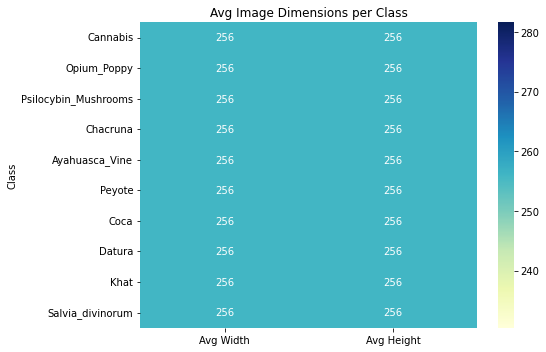

In [16]:
plt.figure(figsize=(8, len(df)*0.5))
heat_df = df.set_index("Class")[["Avg Width", "Avg Height"]]
sns.heatmap(heat_df, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Avg Image Dimensions per Class")
plt.tight_layout()
plt.show()

#### Boxplot for image count

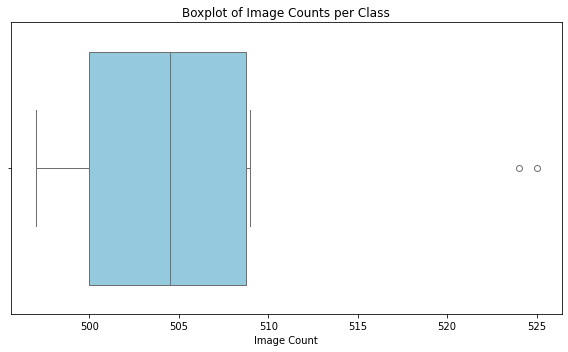

In [17]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["Image Count"], color='skyblue')
plt.title("Boxplot of Image Counts per Class")
plt.tight_layout()
plt.show()

#### Sorted images count

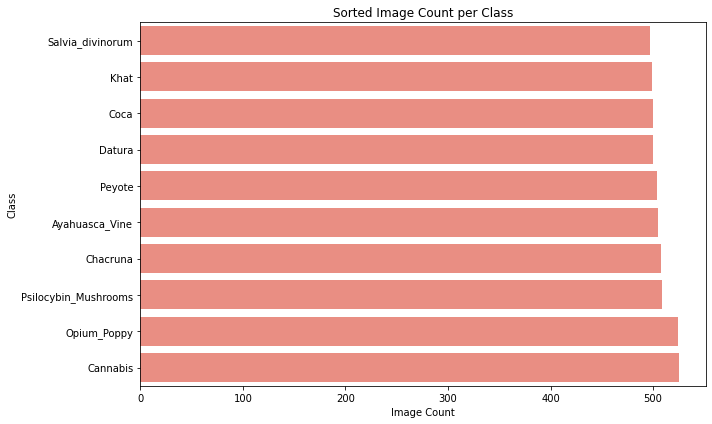

In [18]:
plt.figure(figsize=(10, 6))
df_sorted = df.sort_values("Image Count", ascending=True)
sns.barplot(data=df_sorted, x="Image Count", y="Class", color='salmon')
plt.title("Sorted Image Count per Class")
plt.tight_layout()
plt.show()

### Plant Healthy Dataset

In [19]:
dataset_path = "/user/ychittur/DL/Final Project/Dataset/PlantHealthy"
dataset = ImageFolder(dataset_path)

In [20]:
class_counts = defaultdict(int)
widths = defaultdict(list)
heights = defaultdict(list)
sample_images = {}  

for img_path, label in dataset.samples:
    class_name = dataset.classes[label]
    if class_name not in sample_images:
        sample_images[class_name] = img_path
    image = Image.open(img_path)
    if image.mode == 'P':
        image = image.convert("RGBA")
    else:
        image = image.convert("RGB")
    w, h = image.size
    class_counts[class_name] += 1
    widths[class_name].append(w)
    heights[class_name].append(h)

records = []
for cls in class_counts:
    records.append({
        "Class": cls,
        "Image Count": class_counts[cls],
        "Avg Width": sum(widths[cls]) // len(widths[cls]),
        "Avg Height": sum(heights[cls]) // len(heights[cls]),
        "Sample Image Path": sample_images[cls]
    })

df = pd.DataFrame(records).sort_values("Image Count", ascending=False)

#### Data Statistics

In [21]:
print("\n DataFrame Info:\n")
print(df.info())


 DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 3
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Class              14 non-null     object
 1   Image Count        14 non-null     int64 
 2   Avg Width          14 non-null     int64 
 3   Avg Height         14 non-null     int64 
 4   Sample Image Path  14 non-null     object
dtypes: int64(3), object(2)
memory usage: 672.0+ bytes
None


In [22]:
print("\n Dataset Summary")
print(f"Total Images      : {df['Image Count'].sum()}")
print(f"Total Classes     : {len(df)}")
print(f"Max Images/Class  : {df['Image Count'].max()} ({df.iloc[0]['Class']})")
print(f"Min Images/Class  : {df['Image Count'].min()} ({df.iloc[-1]['Class']})")
print(f"Average Img Count : {int(df['Image Count'].mean())}")
print(f"Avg Image Width   : {int(df['Avg Width'].mean())}")
print(f"Avg Image Height  : {int(df['Avg Height'].mean())}")


 Dataset Summary
Total Images      : 38449
Total Classes     : 14
Max Images/Class  : 4234 (Apple Healthy)
Min Images/Class  : 87 (Citrus Healthy)
Average Img Count : 2746
Avg Image Width   : 285
Avg Image Height  : 306


#### Sample Images

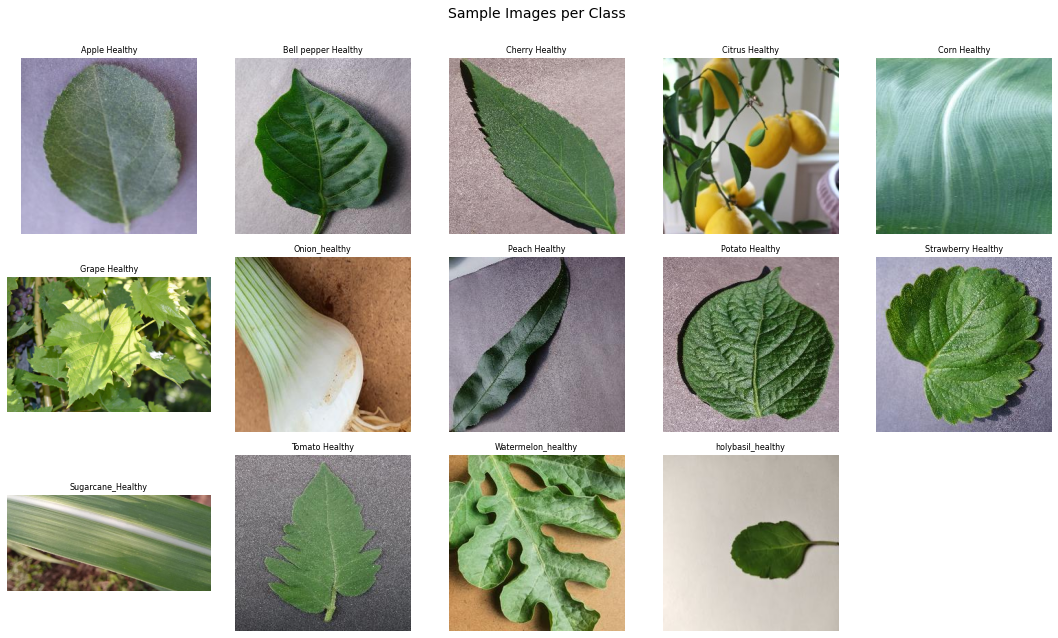

In [23]:
def show_class_samples(df):
    num_classes = len(df)
    cols = 5
    rows = (num_classes + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))

    for i, row in df.iterrows():
        img = Image.open(row["Sample Image Path"])
        if img.mode == 'P':
            img = img.convert("RGBA")
        else:
            img = img.convert("RGB")
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(row["Class"], fontsize=8)
        plt.axis("off")

    plt.suptitle("Sample Images per Class", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

show_class_samples(df)

#### Images count per class

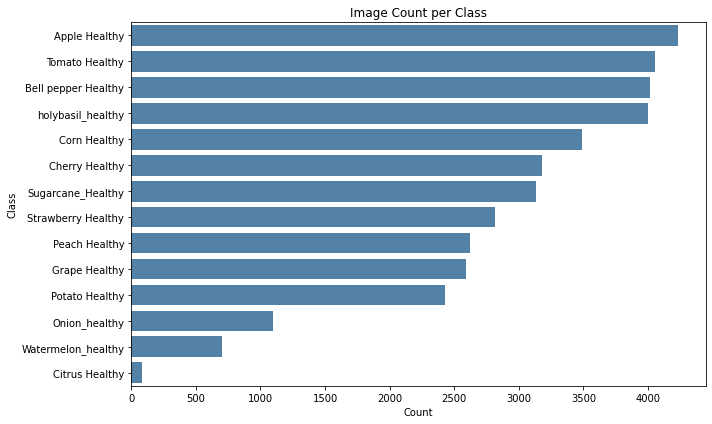

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, y="Class", x="Image Count", color='steelblue')
plt.title("Image Count per Class")
plt.xlabel("Count")
plt.ylabel("Class")
plt.tight_layout()
plt.show()

#### Class Distribution

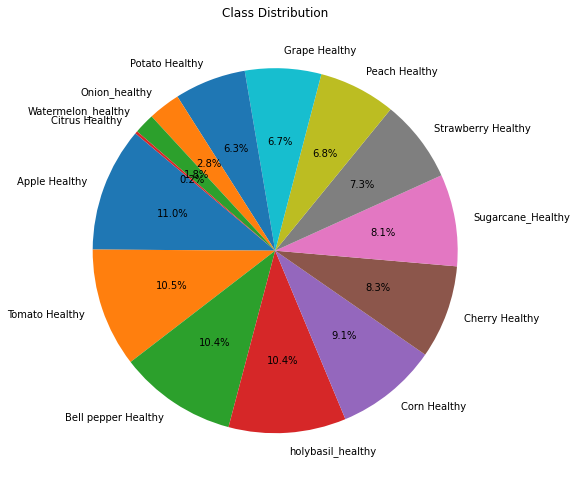

In [25]:
plt.figure(figsize=(8, 8))
plt.pie(df["Image Count"], labels=df["Class"], autopct="%1.1f%%", startangle=140)
plt.title("Class Distribution")
plt.tight_layout()
plt.show()

#### Avg Image dimensions

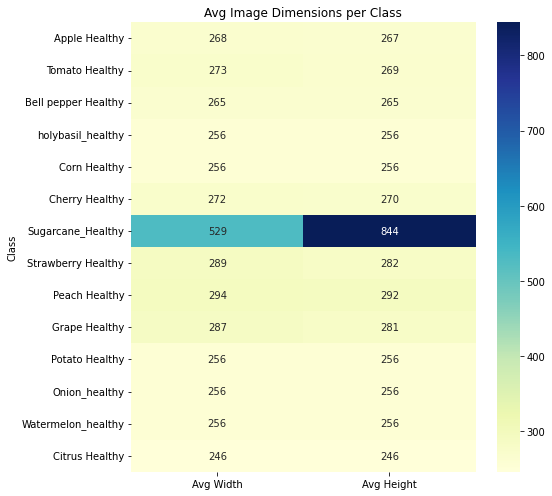

In [26]:
plt.figure(figsize=(8, len(df)*0.5))
heat_df = df.set_index("Class")[["Avg Width", "Avg Height"]]
sns.heatmap(heat_df, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Avg Image Dimensions per Class")
plt.tight_layout()
plt.show()

#### Boxplot of images count

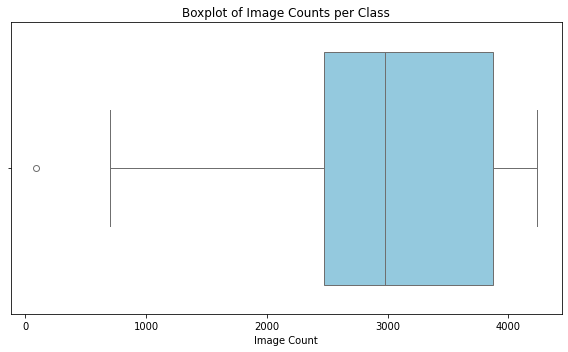

In [27]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["Image Count"], color='skyblue')
plt.title("Boxplot of Image Counts per Class")
plt.tight_layout()
plt.show()

#### Sorted images count per class

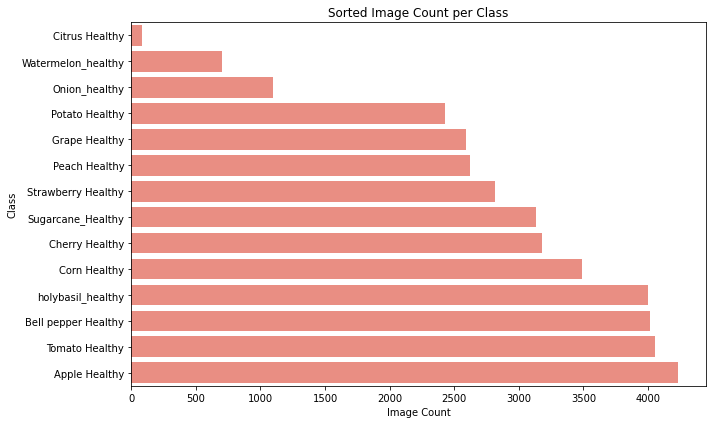

In [28]:
plt.figure(figsize=(10, 6))
df_sorted = df.sort_values("Image Count", ascending=True)
sns.barplot(data=df_sorted, x="Image Count", y="Class", color='salmon')
plt.title("Sorted Image Count per Class")
plt.tight_layout()
plt.show()

### Plant Disease Dataset

In [29]:
dataset_path = "/user/ychittur/DL/Final Project/Dataset/PlantDiseases"

In [30]:
records = []
sample_images = {}
image_counts = defaultdict(int)
widths, heights = defaultdict(list), defaultdict(list)

for crop in os.listdir(dataset_path):
    crop_path = os.path.join(dataset_path, crop)
    if not os.path.isdir(crop_path): continue

    for disease in os.listdir(crop_path):
        disease_path = os.path.join(crop_path, disease)
        if not os.path.isdir(disease_path): continue

        label = f"{crop} – {disease}"
        for file in os.listdir(disease_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(disease_path, file)
                try:
                    img = Image.open(file_path)
                    if img.mode == 'P':
                        img = img.convert("RGBA")
                    else:
                        img = img.convert("RGB")
                    w, h = img.size
                    image_counts[label] += 1
                    widths[label].append(w)
                    heights[label].append(h)
                    if label not in sample_images:
                        sample_images[label] = file_path
                except:
                    continue


df = pd.DataFrame([{
    "Class": label,
    "Image Count": image_counts[label],
    "Avg Width": int(sum(widths[label]) / len(widths[label])),
    "Avg Height": int(sum(heights[label]) / len(heights[label])),
    "Sample Image Path": sample_images[label]
} for label in image_counts])

df = df.sort_values("Image Count", ascending=False)

#### Data Statistics

In [31]:
print("\n DataFrame Info:\n")
print(df.info())


 DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 34 to 5
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Class              36 non-null     object
 1   Image Count        36 non-null     int64 
 2   Avg Width          36 non-null     int64 
 3   Avg Height         36 non-null     int64 
 4   Sample Image Path  36 non-null     object
dtypes: int64(3), object(2)
memory usage: 1.7+ KB
None


In [32]:
print("\n Dataset Summary")
print(f"Total Images      : {df['Image Count'].sum()}")
print(f"Total Classes     : {len(df)}")
print(f"Max Images/Class  : {df['Image Count'].max()} ({df.iloc[0]['Class']})")
print(f"Min Images/Class  : {df['Image Count'].min()} ({df.iloc[-1]['Class']})")
print(f"Average Img Count : {int(df['Image Count'].mean())}")
print(f"Avg Image Width   : {int(df['Avg Width'].mean())}")
print(f"Avg Image Height  : {int(df['Avg Height'].mean())}")


 Dataset Summary
Total Images      : 121981
Total Classes     : 36
Max Images/Class  : 7877 (Tomato – Tomato Yellow Leaf Curl Virus)
Min Images/Class  : 311 (Citrus – Citrus Black spot)
Average Img Count : 3388
Avg Image Width   : 301
Avg Image Height  : 325


#### Sample Images

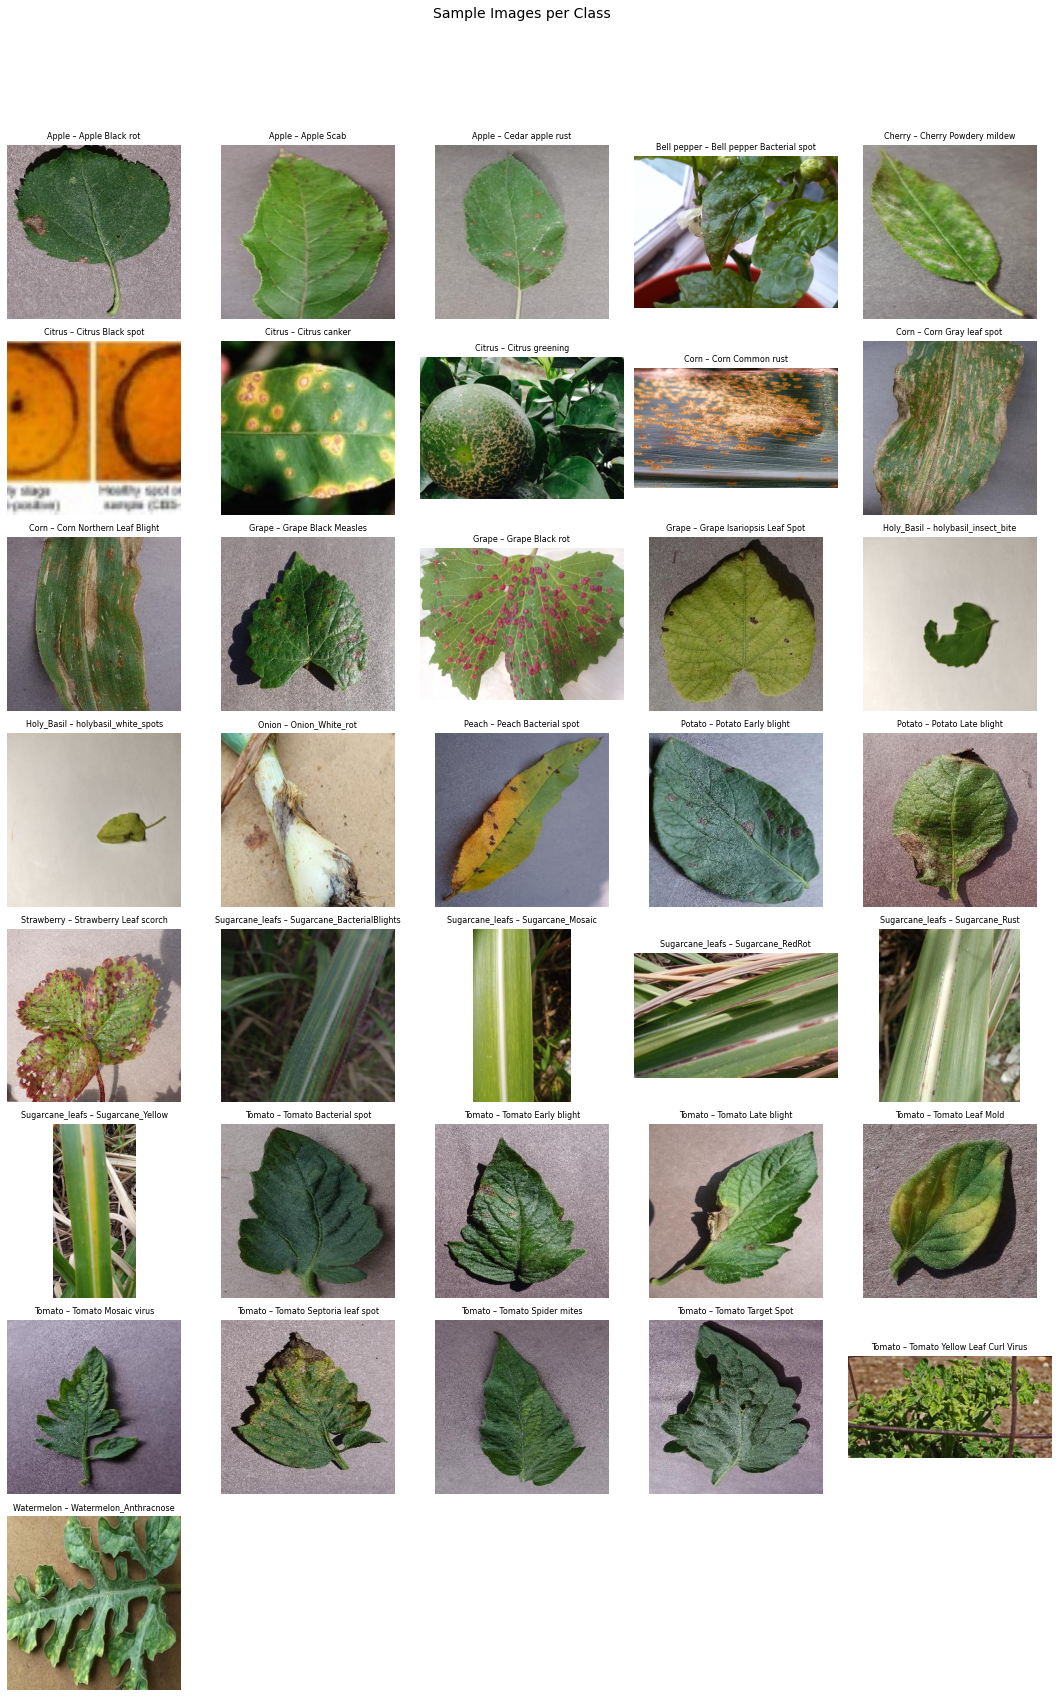

In [33]:
def show_class_samples(df):
    num_classes = len(df)
    cols = 5
    rows = (num_classes + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))

    for i, row in df.iterrows():
        img = Image.open(row["Sample Image Path"])
        if img.mode == 'P':
            img = img.convert("RGBA")
        else:
            img = img.convert("RGB")
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(row["Class"], fontsize=8)
        plt.axis("off")

    plt.suptitle("Sample Images per Class", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

show_class_samples(df)

#### Image count per class

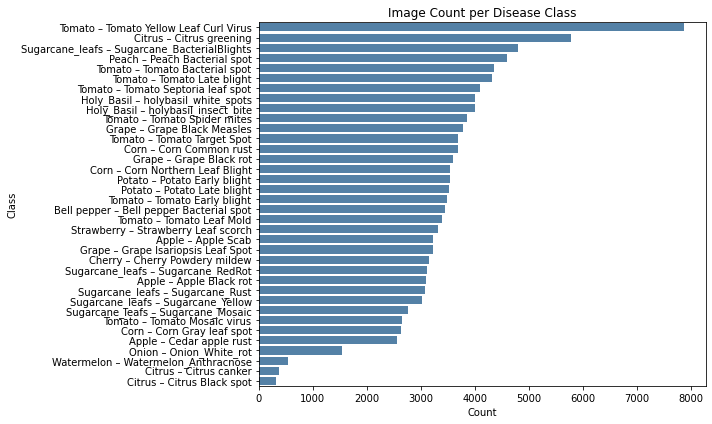

In [34]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, y="Class", x="Image Count", color='steelblue')
plt.title("Image Count per Disease Class")
plt.xlabel("Count")
plt.ylabel("Class")
plt.tight_layout()
plt.show()

#### Class Distribution

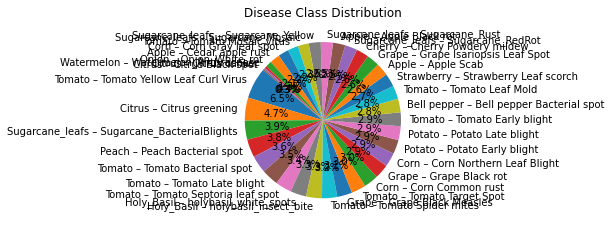

In [35]:
plt.figure(figsize=(8, 8))
plt.pie(df["Image Count"], labels=df["Class"], autopct="%1.1f%%", startangle=140)
plt.title("Disease Class Distribution")
plt.tight_layout()
plt.show()

#### Avg image dimensions

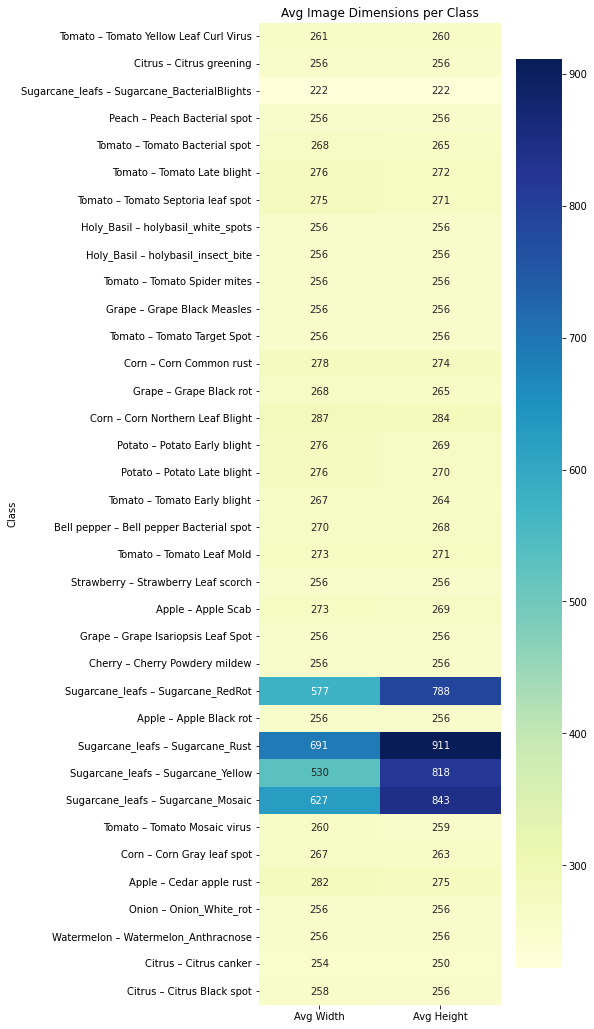

In [36]:
plt.figure(figsize=(8, len(df)*0.4))
sns.heatmap(df.set_index("Class")[["Avg Width", "Avg Height"]], annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Avg Image Dimensions per Class")
plt.tight_layout()
plt.show()

#### Boxplot of images count

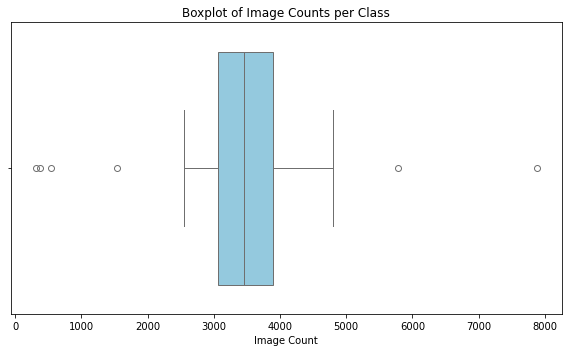

In [37]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["Image Count"], color='skyblue')
plt.title("Boxplot of Image Counts per Class")
plt.tight_layout()
plt.show()

#### Sorted image count per class

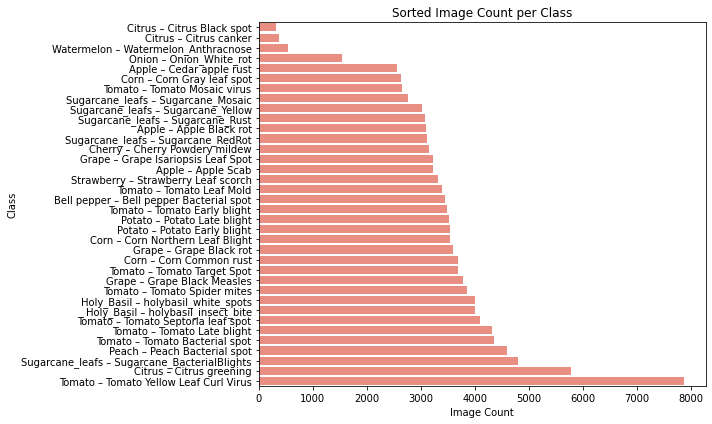

In [38]:
plt.figure(figsize=(10, 6))
df_sorted = df.sort_values("Image Count", ascending=True)
sns.barplot(data=df_sorted, x="Image Count", y="Class", color='salmon')
plt.title("Sorted Image Count per Class")
plt.tight_layout()
plt.show()

## Model Training & Validation

### Binary Legal vs Illegal Classifier

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.fc(self.conv(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_DIR = "/user/ychittur/DL/Final Project/Dataset/Illegal_Binary"

common_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_aug_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=transform)

    def __getitem__(self, index):
        path, label = self.samples[index]
        img = Image.open(path).convert('RGB') 
        if self.transform:
            img = self.transform(img)
        return img, label

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.fc(self.conv(x))

full_dataset = CustomImageFolder(DATA_DIR)

total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])
train_set.dataset.transform = train_aug_transforms
val_set.dataset.transform = common_transforms
test_set.dataset.transform = common_transforms

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

model = CustomCNN(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []
epoch_times = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    correct = total = train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss /= len(train_loader)

    model.eval()
    correct = total = val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    val_loss /= len(val_loader)
    epoch_time = time.time() - start_time

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    epoch_times.append(epoch_time)

    print(f"Epoch [{epoch+1}/{num_epochs}]  {epoch_time:.2f}s | "
          f"Train Acc: {train_acc:.2f}%, Loss: {train_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}%, Loss: {val_loss:.4f}")

torch.save(model.state_dict(), "illegal_binary_classifier.pth")


Epoch [1/10]  13.08s | Train Acc: 89.25%, Loss: 0.3327 | Val Acc: 93.31%, Loss: 0.1930
Epoch [2/10]  11.97s | Train Acc: 96.06%, Loss: 0.1111 | Val Acc: 97.09%, Loss: 0.0857
Epoch [3/10]  11.78s | Train Acc: 97.12%, Loss: 0.0829 | Val Acc: 92.85%, Loss: 0.2003
Epoch [4/10]  11.71s | Train Acc: 97.72%, Loss: 0.0681 | Val Acc: 86.95%, Loss: 0.3002
Epoch [5/10]  10.74s | Train Acc: 97.63%, Loss: 0.0693 | Val Acc: 96.16%, Loss: 0.1113
Epoch [6/10]  10.55s | Train Acc: 98.91%, Loss: 0.0281 | Val Acc: 98.01%, Loss: 0.0748
Epoch [7/10]  10.75s | Train Acc: 99.40%, Loss: 0.0155 | Val Acc: 97.68%, Loss: 0.0733
Epoch [8/10]  12.65s | Train Acc: 99.26%, Loss: 0.0194 | Val Acc: 97.48%, Loss: 0.0846
Epoch [9/10]  12.70s | Train Acc: 99.11%, Loss: 0.0301 | Val Acc: 97.35%, Loss: 0.1039
Epoch [10/10]  12.56s | Train Acc: 99.35%, Loss: 0.0199 | Val Acc: 97.95%, Loss: 0.0920


#### Training and Validation Graphs

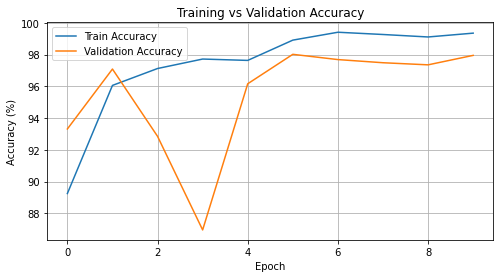

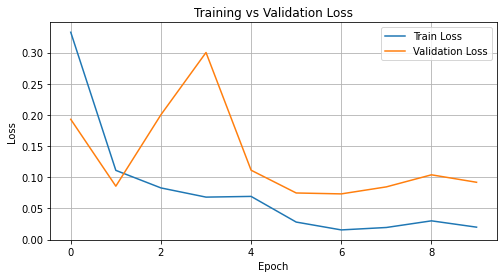

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


#### Testing


 Test Classification Report:
              precision    recall  f1-score   support

       Legal       0.98      0.97      0.97       737
     illegal       0.97      0.98      0.98       774

    accuracy                           0.98      1511
   macro avg       0.98      0.98      0.98      1511
weighted avg       0.98      0.98      0.98      1511



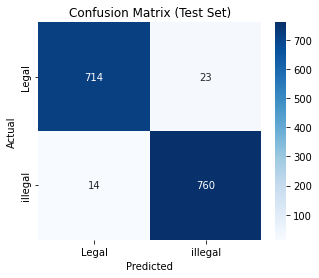

In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("\n Test Classification Report:")
print(classification_report(y_true, y_pred, target_names=full_dataset.classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Illegal class Classifier

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.fc(self.conv(x))

DATA_DIR = "/user/ychittur/DL/Final Project/Dataset/illegal"

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

class CustomImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, label = self.samples[index]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

full_dataset = CustomImageFolder(DATA_DIR)

total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])
train_set.dataset.transform = train_transforms
val_set.dataset.transform = val_test_transforms
test_set.dataset.transform = val_test_transforms

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

num_classes = len(full_dataset.classes)
model = CustomCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []
epoch_times = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    correct = total = train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss /= len(train_loader)

    model.eval()
    correct = total = val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_acc = 100 * correct / total
    val_loss /= len(val_loader)
    epoch_time = time.time() - start_time

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    epoch_times.append(epoch_time)

    print(f"Epoch [{epoch+1}/{num_epochs}]  {epoch_time:.2f}s | "
          f"Train Acc: {train_acc:.2f}%, Loss: {train_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}%, Loss: {val_loss:.4f}")

torch.save(model.state_dict(), "illegal_crop_type_classifier.pth")

Epoch [1/10]  5.59s | Train Acc: 18.71%, Loss: 2.3057 | Val Acc: 28.82%, Loss: 2.0180
Epoch [2/10]  5.41s | Train Acc: 32.43%, Loss: 1.8856 | Val Acc: 39.34%, Loss: 1.7031
Epoch [3/10]  5.63s | Train Acc: 51.79%, Loss: 1.4239 | Val Acc: 54.21%, Loss: 1.3393
Epoch [4/10]  5.91s | Train Acc: 73.18%, Loss: 0.8383 | Val Acc: 69.74%, Loss: 1.0097
Epoch [5/10]  5.93s | Train Acc: 87.60%, Loss: 0.3918 | Val Acc: 74.74%, Loss: 0.9719
Epoch [6/10]  6.19s | Train Acc: 93.46%, Loss: 0.2381 | Val Acc: 77.76%, Loss: 0.9755
Epoch [7/10]  5.98s | Train Acc: 96.51%, Loss: 0.1365 | Val Acc: 77.89%, Loss: 0.9939
Epoch [8/10]  5.95s | Train Acc: 96.73%, Loss: 0.1187 | Val Acc: 77.89%, Loss: 1.1112
Epoch [9/10]  5.77s | Train Acc: 97.80%, Loss: 0.0745 | Val Acc: 78.29%, Loss: 1.1141
Epoch [10/10]  6.05s | Train Acc: 97.86%, Loss: 0.0823 | Val Acc: 77.63%, Loss: 1.2146


#### Training and Validation Graphs

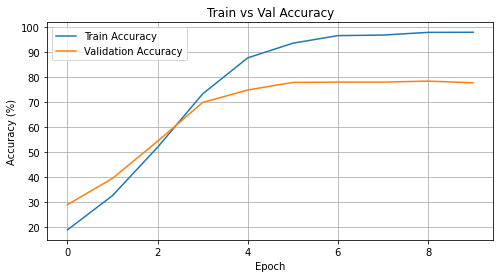

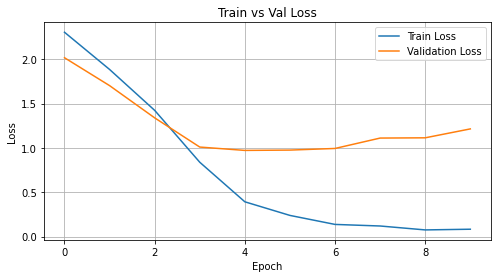

In [23]:
plt.figure(figsize=(8, 4))
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Val Accuracy")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.grid(True)
plt.legend()
plt.show()


#### Testing


 Classification Report (Test Set):
                      precision    recall  f1-score   support

      Ayahuasca_Vine       0.73      0.72      0.73        72
            Cannabis       0.74      0.67      0.70        81
            Chacruna       0.63      0.81      0.71        68
                Coca       0.79      0.89      0.84        85
              Datura       0.73      0.62      0.67        76
                Khat       0.77      0.73      0.75        86
         Opium_Poppy       0.63      0.76      0.69        75
              Peyote       0.92      0.83      0.87        71
Psilocybin_Mushrooms       0.83      0.85      0.84        80
    Salvia_divinorum       0.91      0.71      0.79        68

            accuracy                           0.76       762
           macro avg       0.77      0.76      0.76       762
        weighted avg       0.77      0.76      0.76       762



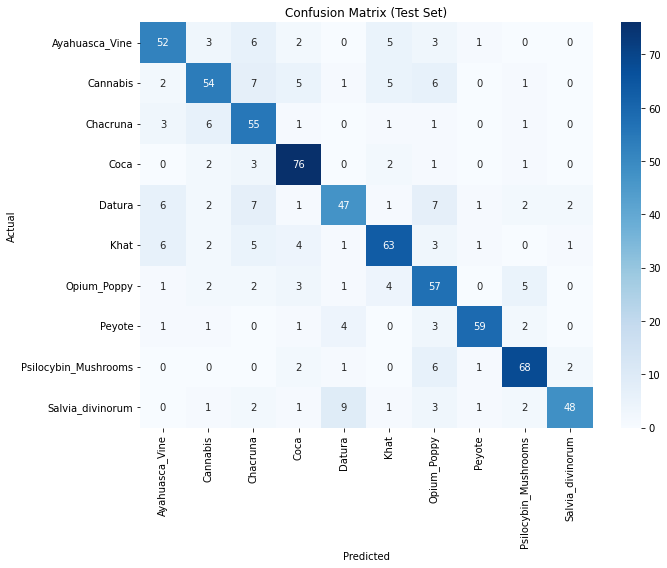

In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\n Classification Report (Test Set):")
print(classification_report(y_true, y_pred, target_names=full_dataset.classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

### Healthy vs Disease Classifier

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

healthy_root = "/user/ychittur/DL/Final Project/Dataset/PlantHealthy"
diseased_root = "/user/ychittur/DL/Final Project/Dataset/PlantDiseases"

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

class HealthyDiseasedDataset(Dataset):
    def __init__(self, healthy_dir, diseased_dir, transform=None):
        self.samples = []
        self.transform = transform

        for folder in os.listdir(healthy_dir):
            folder_path = os.path.join(healthy_dir, folder)
            for img_name in os.listdir(folder_path):
                self.samples.append((os.path.join(folder_path, img_name), 0))

        for crop in os.listdir(diseased_dir):
            crop_path = os.path.join(diseased_dir, crop)
            if os.path.isdir(crop_path):
                for disease in os.listdir(crop_path):
                    disease_path = os.path.join(crop_path, disease)
                    for img_name in os.listdir(disease_path):
                        self.samples.append((os.path.join(disease_path, img_name), 1))

        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, label = self.samples[index]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

full_dataset = HealthyDiseasedDataset(healthy_root, diseased_root)

total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])
train_set.dataset.transform = train_transforms
val_set.dataset.transform = test_transforms
test_set.dataset.transform = test_transforms

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

model = CustomCNN(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []

for epoch in range(num_epochs):
    start = time.time()
    model.train()
    correct = total = train_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss /= len(train_loader)

    model.eval()
    correct = total = val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_acc = 100 * correct / total
    val_loss /= len(val_loader)

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Acc: {train_acc:.2f}%, Loss: {train_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}%, Loss: {val_loss:.4f} | "
          f"Time: {time.time() - start:.2f}s")

torch.save(model.state_dict(), "healthy_vs_diseased_classifier.pth")

Epoch [1/10] | Train Acc: 91.82%, Loss: 0.2088 | Val Acc: 95.70%, Loss: 0.1166 | Time: 224.84s
Epoch [2/10] | Train Acc: 96.31%, Loss: 0.1026 | Val Acc: 96.85%, Loss: 0.0924 | Time: 190.67s
Epoch [3/10] | Train Acc: 97.18%, Loss: 0.0780 | Val Acc: 96.75%, Loss: 0.0955 | Time: 190.13s
Epoch [4/10] | Train Acc: 97.97%, Loss: 0.0577 | Val Acc: 97.29%, Loss: 0.0915 | Time: 187.90s
Epoch [5/10] | Train Acc: 98.16%, Loss: 0.0526 | Val Acc: 97.31%, Loss: 0.0850 | Time: 186.52s
Epoch [6/10] | Train Acc: 98.45%, Loss: 0.0442 | Val Acc: 97.68%, Loss: 0.0766 | Time: 189.34s
Epoch [7/10] | Train Acc: 98.61%, Loss: 0.0409 | Val Acc: 96.83%, Loss: 0.0935 | Time: 188.98s
Epoch [8/10] | Train Acc: 98.86%, Loss: 0.0366 | Val Acc: 97.73%, Loss: 0.0842 | Time: 191.56s
Epoch [9/10] | Train Acc: 98.89%, Loss: 0.0347 | Val Acc: 97.36%, Loss: 0.0958 | Time: 183.75s
Epoch [10/10] | Train Acc: 98.89%, Loss: 0.0347 | Val Acc: 97.74%, Loss: 0.0949 | Time: 188.86s


#### Training and Validation Graphs

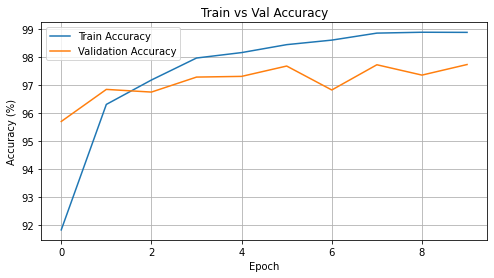

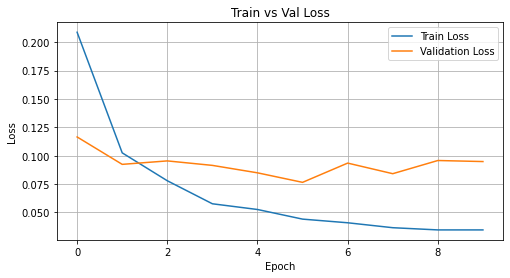

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Val Accuracy")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.grid(True)
plt.legend()
plt.show()


#### Testing


Classification Report (Test Set):
              precision    recall  f1-score   support

     Healthy       0.96      0.93      0.95      5890
    Diseased       0.98      0.99      0.98     18176

    accuracy                           0.97     24066
   macro avg       0.97      0.96      0.96     24066
weighted avg       0.97      0.97      0.97     24066



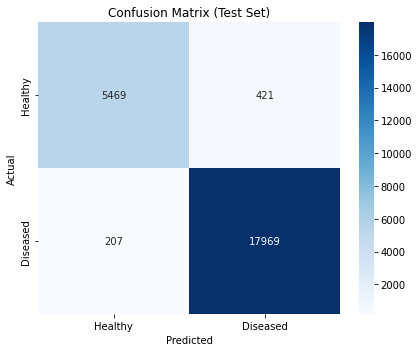

In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

class_names = ["Healthy", "Diseased"]
print("\nClassification Report (Test Set):")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

### Healthy Class Classifier

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

healthy_root = "/user/ychittur/DL/Final Project/Dataset/PlantHealthy"

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

class_names = sorted(os.listdir(healthy_root))
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}
idx_to_class = {idx: cls_name for cls_name, idx in class_to_idx.items()}

class HealthyCropDataset(Dataset):
    def __init__(self, root, transform=None):
        self.samples = []
        self.transform = transform
        for class_name in os.listdir(root):
            class_path = os.path.join(root, class_name)
            if os.path.isdir(class_path):
                for img in os.listdir(class_path):
                    self.samples.append((os.path.join(class_path, img), class_to_idx[class_name]))
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, label = self.samples[index]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

full_dataset = HealthyCropDataset(healthy_root)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])
train_set.dataset.transform = train_transforms
val_set.dataset.transform = test_transforms
test_set.dataset.transform = test_transforms

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 256), nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = len(class_names)
model = CustomCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []

for epoch in range(num_epochs):
    model.train()
    correct = total = train_loss = 0
    start = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss /= len(train_loader)

    model.eval()
    correct = total = val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_acc = 100 * correct / total
    val_loss /= len(val_loader)

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Acc: {train_acc:.2f}%, Loss: {train_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}%, Loss: {val_loss:.4f} | "
          f"Time: {time.time() - start:.2f}s")

torch.save(model.state_dict(), "healthy_crop_classifier.pth")

Epoch [1/10] | Train Acc: 83.46%, Loss: 0.5338 | Val Acc: 94.45%, Loss: 0.1891 | Time: 48.58s
Epoch [2/10] | Train Acc: 94.03%, Loss: 0.1925 | Val Acc: 96.27%, Loss: 0.1312 | Time: 50.71s
Epoch [3/10] | Train Acc: 95.75%, Loss: 0.1360 | Val Acc: 96.77%, Loss: 0.1223 | Time: 49.84s
Epoch [4/10] | Train Acc: 96.86%, Loss: 0.0980 | Val Acc: 97.21%, Loss: 0.1263 | Time: 47.20s
Epoch [5/10] | Train Acc: 97.44%, Loss: 0.0837 | Val Acc: 97.82%, Loss: 0.1015 | Time: 52.34s
Epoch [6/10] | Train Acc: 97.59%, Loss: 0.0727 | Val Acc: 97.82%, Loss: 0.1032 | Time: 46.61s
Epoch [7/10] | Train Acc: 97.92%, Loss: 0.0676 | Val Acc: 97.57%, Loss: 0.1107 | Time: 47.40s
Epoch [8/10] | Train Acc: 98.59%, Loss: 0.0449 | Val Acc: 97.76%, Loss: 0.1393 | Time: 46.58s
Epoch [9/10] | Train Acc: 98.34%, Loss: 0.0568 | Val Acc: 97.64%, Loss: 0.1314 | Time: 49.19s
Epoch [10/10] | Train Acc: 98.69%, Loss: 0.0442 | Val Acc: 97.68%, Loss: 0.1207 | Time: 46.73s


#### Training and Validation Graphs

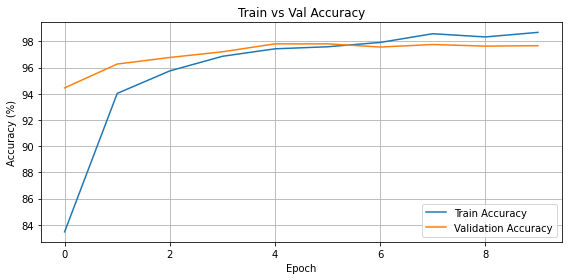

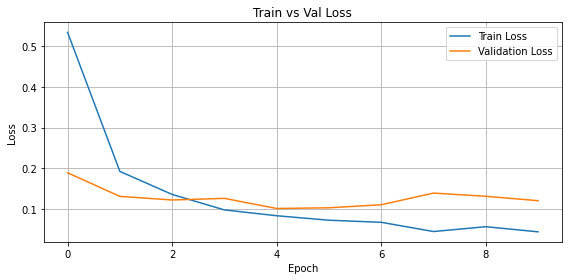

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Val Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Testing


Classification Report (Test Set):
                     precision    recall  f1-score   support

      Apple Healthy       0.98      0.96      0.97       633
Bell pepper Healthy       0.97      0.95      0.96       545
     Cherry Healthy       0.95      0.99      0.97       483
     Citrus Healthy       0.75      0.50      0.60         6
       Corn Healthy       0.97      1.00      0.99       503
      Grape Healthy       0.96      0.97      0.97       400
      Onion_healthy       1.00      1.00      1.00       177
      Peach Healthy       0.95      0.96      0.95       402
     Potato Healthy       0.97      0.99      0.98       361
 Strawberry Healthy       0.97      0.94      0.96       417
  Sugarcane_Healthy       0.97      0.99      0.98       484
     Tomato Healthy       1.00      0.97      0.99       630
 Watermelon_healthy       0.98      0.95      0.96       116
  holybasil_healthy       1.00      1.00      1.00       611

           accuracy                           0.

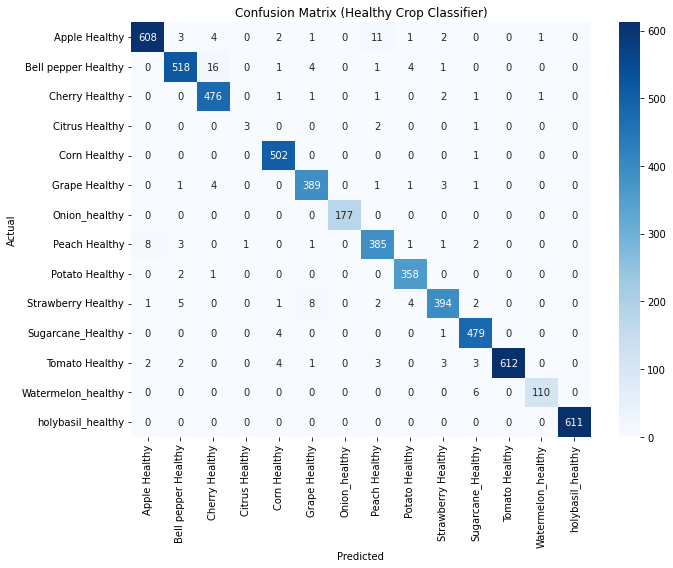

In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report (Test Set):")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix (Healthy Crop Classifier)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

### Disease Classifier

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
disease_root = "/user/ychittur/DL/Final Project/Dataset/PlantDiseases"

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

class_names = []
for crop in sorted(os.listdir(disease_root)):
    crop_path = os.path.join(disease_root, crop)
    if os.path.isdir(crop_path):
        for disease in sorted(os.listdir(crop_path)):
            class_names.append(f"{crop} – {disease}")

class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

class DiseaseDataset(Dataset):
    def __init__(self, root, transform=None):
        self.samples = []
        self.transform = transform

        for crop in os.listdir(root):
            crop_path = os.path.join(root, crop)
            if os.path.isdir(crop_path):
                for disease in os.listdir(crop_path):
                    disease_path = os.path.join(crop_path, disease)
                    label = f"{crop} – {disease}"
                    for img in os.listdir(disease_path):
                        self.samples.append((os.path.join(disease_path, img), class_to_idx[label]))

        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

full_dataset = DiseaseDataset(disease_root)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])
train_set.dataset.transform = train_transforms
val_set.dataset.transform = test_transforms
test_set.dataset.transform = test_transforms

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 256), nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = len(class_names)
model = CustomCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    correct = total = train_loss = 0
    start = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss /= len(train_loader)

    model.eval()
    correct = total = val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_acc = 100 * correct / total
    val_loss /= len(val_loader)

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Acc: {train_acc:.2f}%, Loss: {train_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}%, Loss: {val_loss:.4f} | "
          f"Time: {time.time() - start:.2f}s")

torch.save(model.state_dict(), "disease_classifier.pth")

Epoch [1/10] | Train Acc: 67.95%, Loss: 1.0440 | Val Acc: 85.41%, Loss: 0.4674 | Time: 143.14s
Epoch [2/10] | Train Acc: 83.66%, Loss: 0.5153 | Val Acc: 88.48%, Loss: 0.3700 | Time: 151.98s
Epoch [3/10] | Train Acc: 88.82%, Loss: 0.3514 | Val Acc: 91.91%, Loss: 0.2597 | Time: 147.48s
Epoch [4/10] | Train Acc: 91.61%, Loss: 0.2645 | Val Acc: 92.06%, Loss: 0.2679 | Time: 144.50s
Epoch [5/10] | Train Acc: 93.47%, Loss: 0.2047 | Val Acc: 92.64%, Loss: 0.2551 | Time: 142.49s
Epoch [6/10] | Train Acc: 94.69%, Loss: 0.1715 | Val Acc: 92.81%, Loss: 0.2673 | Time: 148.21s
Epoch [7/10] | Train Acc: 95.34%, Loss: 0.1472 | Val Acc: 92.75%, Loss: 0.2805 | Time: 146.95s
Epoch [8/10] | Train Acc: 95.93%, Loss: 0.1306 | Val Acc: 93.19%, Loss: 0.2940 | Time: 147.26s
Epoch [9/10] | Train Acc: 96.16%, Loss: 0.1246 | Val Acc: 93.30%, Loss: 0.3001 | Time: 155.21s
Epoch [10/10] | Train Acc: 96.55%, Loss: 0.1155 | Val Acc: 93.05%, Loss: 0.3239 | Time: 147.18s


#### Training and Validation Graphs

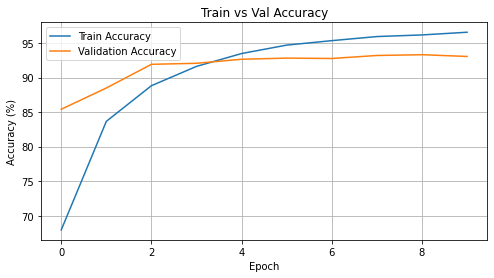

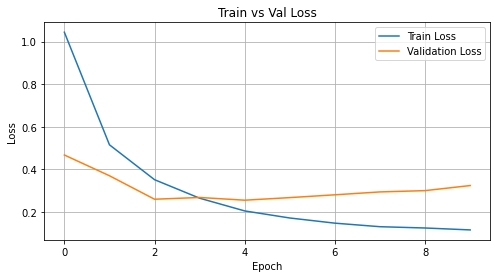

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Val Accuracy")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.grid(True)
plt.legend()
plt.show()

#### Testing


Classification Report:
                                              precision    recall  f1-score   support

                     Apple – Apple Black rot       0.95      0.98      0.97       457
                          Apple – Apple Scab       0.92      0.94      0.93       457
                    Apple – Cedar apple rust       0.97      0.93      0.95       401
    Bell pepper – Bell pepper Bacterial spot       0.93      0.96      0.95       532
              Cherry – Cherry Powdery mildew       0.99      0.99      0.99       479
                  Citrus – Citrus Black spot       0.54      0.68      0.60        56
                      Citrus – Citrus canker       0.58      0.68      0.63        53
                    Citrus – Citrus greening       0.96      0.96      0.96       846
                     Corn – Corn Common rust       0.98      0.97      0.97       537
                  Corn – Corn Gray leaf spot       0.92      0.92      0.92       385
            Corn – Corn North

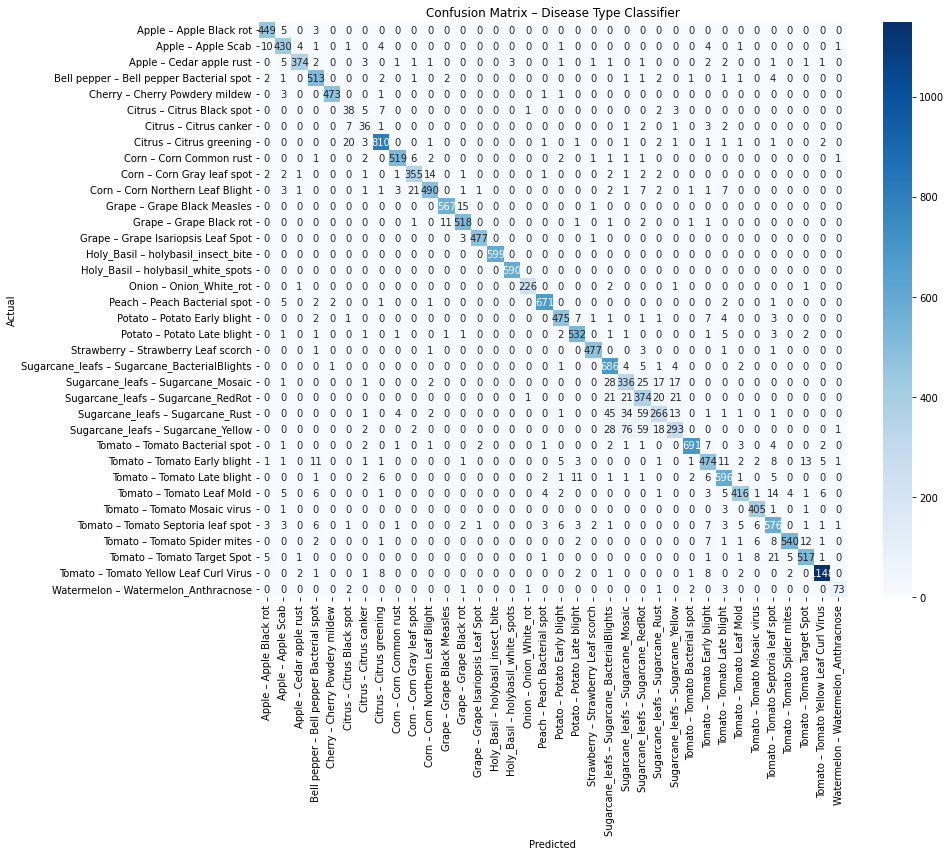

In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())



unique_classes = sorted(set(y_true + y_pred))
print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    labels=unique_classes,
    target_names=[idx_to_class[i] for i in unique_classes]
))

cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    annot=True, 
    fmt='d',     
    cmap='Blues',
    xticklabels=[idx_to_class[i] for i in unique_classes],
    yticklabels=[idx_to_class[i] for i in unique_classes]
)
plt.title("Confusion Matrix – Disease Type Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## AgroInspector Pipeline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_path = "/user/ychittur/DL/Final Project"
dataset_path = os.path.join(base_path, "Dataset")
output_csv = os.path.join(base_path, "agroinspector_results.csv")

infer_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

class CustomCNNConv(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.fc(self.conv(x))

class CustomCNNFeatures(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))


def load_model(path, num_classes, arch='conv'):
    if arch == 'conv':
        model = CustomCNNConv(num_classes)
    elif arch == 'features':
        model = CustomCNNFeatures(num_classes)
    else:
        raise ValueError("Invalid arch type")
    
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    return model


model1 = load_model("illegal_binary_classifier.pth", 2, arch="conv")
model2 = load_model("illegal_crop_type_classifier.pth", 10, arch="conv")
model3 = load_model("healthy_vs_diseased_classifier.pth", 2, arch="features")   
model4 = load_model("disease_classifier.pth", 46, arch="features")              
model5 = load_model("healthy_crop_classifier.pth", 14, arch="features")


illegal_crop_types = sorted(os.listdir(os.path.join(dataset_path, "illegal")))

disease_types = []
for crop in os.listdir(os.path.join(dataset_path, "PlantDiseases")):
    for disease in os.listdir(os.path.join(dataset_path, "PlantDiseases", crop)):
        disease_types.append(f"{crop} – {disease}")

healthy_crop_classes = sorted(os.listdir(os.path.join(dataset_path, "PlantHealthy")))
healthy_crop_names = [cls.replace("_Healthy", "").replace("_healthy", "").capitalize() for cls in healthy_crop_classes]

def collect_random_images(folder, limit=200):
    image_paths = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(os.path.join(root, file))
    return random.sample(image_paths, min(limit, len(image_paths)))

image_paths = []
image_paths += collect_random_images(os.path.join(dataset_path, "Illegal_Binary", "Legal"), 200)
image_paths += collect_random_images(os.path.join(dataset_path, "Illegal_Binary", "Illegal"), 200)
image_paths += collect_random_images(os.path.join(dataset_path, "illegal"), 200)
image_paths += collect_random_images(os.path.join(dataset_path, "PlantHealthy"), 200)
image_paths += collect_random_images(os.path.join(dataset_path, "PlantDiseases"), 200)

results = []

for img_path in image_paths:
    rel_path = os.path.relpath(img_path, dataset_path)
    parts = rel_path.split(os.sep)

    if "illegal" in parts:
        true_step1 = "Illegal"
        true_crop = parts[1] if parts[0] == "illegal" else ""
        true_step2 = ""
        true_disease = ""
        true_healthy_crop = ""
    elif "PlantHealthy" in parts:
        true_step1 = "Legal"
        true_crop = parts[1].replace("_Healthy", "")
        true_step2 = "Healthy"
        true_disease = ""
        true_healthy_crop = true_crop.capitalize()
    elif "PlantDiseases" in parts:
        true_step1 = "Legal"
        true_crop = parts[1]
        true_step2 = "Diseased"
        true_disease = f"{parts[1]} – {parts[2]}"
        true_healthy_crop = ""
    elif "Illegal_Binary" in parts:
        true_step1 = parts[1].capitalize()
        true_crop = ""
        true_step2 = ""
        true_disease = ""
        true_healthy_crop = ""
    else:
        true_step1 = true_crop = true_step2 = true_disease = true_healthy_crop = ""

    image = Image.open(img_path).convert("RGB")
    tensor = infer_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        pred1 = torch.argmax(model1(tensor)).item()
        step1 = "Legal" if pred1 == 0 else "Illegal"

        step2 = ""
        illegal_type = ""
        disease_type = ""
        healthy_crop_type = ""

        if step1 == "Illegal":
            pred2 = torch.argmax(model2(tensor)).item()
            illegal_type = illegal_crop_types[pred2]
        else:
            pred3 = torch.argmax(model3(tensor)).item()
            step2 = "Healthy" if pred3 == 0 else "Diseased"
            if step2 == "Healthy":
                pred5 = torch.argmax(model5(tensor)).item()
                healthy_crop_type = healthy_crop_names[pred5]
            else:
                pred4 = torch.argmax(model4(tensor)).item()
                disease_type = disease_types[pred4]

    results.append({
        "filename": os.path.basename(img_path),
        "true_step1": true_step1,
        "prediction_step1": step1,
        "true_crop_type": true_crop,
        "illegal_crop_type": illegal_type,
        "true_step2": true_step2,
        "prediction_step2": step2,
        "true_disease_type": true_disease,
        "disease_type": disease_type,
        "true_healthy_crop": true_healthy_crop,
        "predicted_healthy_crop": healthy_crop_type
    })

df = pd.DataFrame(results)
df.to_csv(output_csv, index=False)
print(f"\n Results saved to: {output_csv}")

valid_step1 = df["true_step1"].isin(["Legal", "Illegal"])
step1_acc = accuracy_score(df[valid_step1]["true_step1"], df[valid_step1]["prediction_step1"])

valid_illegal = df["true_step1"] == "Illegal"
illegal_acc = accuracy_score(
    df[valid_illegal & (df["prediction_step1"] == "Illegal")]["true_crop_type"],
    df[valid_illegal & (df["prediction_step1"] == "Illegal")]["illegal_crop_type"]
) if valid_illegal.any() else 0.0

valid_legal = df["true_step1"] == "Legal"
step2_acc = accuracy_score(
    df[valid_legal]["true_step2"],
    df[valid_legal]["prediction_step2"]
) if valid_legal.any() else 0.0

valid_disease = valid_legal & (df["true_step2"] == "Diseased") & (df["prediction_step2"] == "Diseased")
disease_acc = accuracy_score(
    df[valid_disease]["true_disease_type"],
    df[valid_disease]["disease_type"]
) if valid_disease.any() else 0.0

valid_healthy = valid_legal & (df["true_step2"] == "Healthy") & (df["prediction_step2"] == "Healthy")
healthy_acc = accuracy_score(
    df[valid_healthy]["true_healthy_crop"],
    df[valid_healthy]["predicted_healthy_crop"]
) if valid_healthy.any() else 0.0

print("\n AgroInspector Accuracy Summary (Custom CNN Models):")
print(f"Step 1 – Illegal vs Legal       : {step1_acc * 100:.2f}%")
print(f"Step 2 – Illegal Crop Type      : {illegal_acc * 100:.2f}% (on predicted illegal)")
print(f"Step 3 – Healthy vs Diseased    : {step2_acc * 100:.2f}% (on predicted legal)")
print(f"Step 4 – Disease Type           : {disease_acc * 100:.2f}% (on predicted diseased)")
print(f"Step 5 – Healthy Crop Type      : {healthy_acc * 100:.2f}% (on predicted healthy)")



 Results saved to: /user/ychittur/DL/Final Project/agroinspector_results.csv

 AgroInspector Accuracy Summary (Custom CNN Models):
Step 1 – Illegal vs Legal       : 93.62%
Step 2 – Illegal Crop Type      : 93.47% (on predicted illegal)
Step 3 – Healthy vs Diseased    : 59.17% (on predicted legal)
Step 4 – Disease Type           : 98.74% (on predicted diseased)
Step 5 – Healthy Crop Type      : 85.42% (on predicted healthy)


## Autoencoder-Illegal_Binary

 Training Autoencoder...
Epoch [1/10] Autoencoder Loss: 0.1142
Epoch [2/10] Autoencoder Loss: 0.0676
Epoch [3/10] Autoencoder Loss: 0.0530
Epoch [4/10] Autoencoder Loss: 0.0450
Epoch [5/10] Autoencoder Loss: 0.0400
Epoch [6/10] Autoencoder Loss: 0.0364
Epoch [7/10] Autoencoder Loss: 0.0338
Epoch [8/10] Autoencoder Loss: 0.0319
Epoch [9/10] Autoencoder Loss: 0.0295
Epoch [10/10] Autoencoder Loss: 0.0279
 Training Classifier on Encoded Latent Features...
Epoch [1/10] Classifier Loss: 0.3317 | Acc: 85.90%
Epoch [2/10] Classifier Loss: 0.2061 | Acc: 92.20%
Epoch [3/10] Classifier Loss: 0.1656 | Acc: 94.06%
Epoch [4/10] Classifier Loss: 0.1376 | Acc: 95.35%
Epoch [5/10] Classifier Loss: 0.1135 | Acc: 96.41%
Epoch [6/10] Classifier Loss: 0.0950 | Acc: 97.01%
Epoch [7/10] Classifier Loss: 0.0791 | Acc: 97.74%
Epoch [8/10] Classifier Loss: 0.0654 | Acc: 98.23%
Epoch [9/10] Classifier Loss: 0.0558 | Acc: 98.47%
Epoch [10/10] Classifier Loss: 0.0461 | Acc: 98.86%

 Classification Report (Test Se

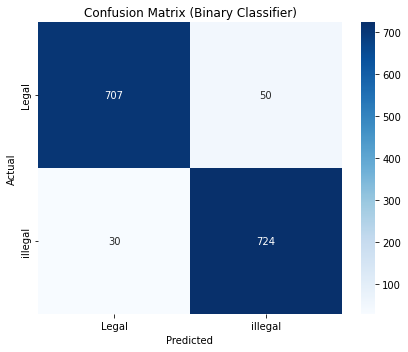

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "/user/ychittur/DL/Final Project/Dataset/Illegal_Binary"
batch_size = 32
image_size = 128
latent_dim = 128
num_epochs = 10

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * (image_size // 4) * (image_size // 4), latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * (image_size // 4) * (image_size // 4)), nn.ReLU(),
            nn.Unflatten(1, (64, image_size // 4, image_size // 4)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

ae = Autoencoder().to(device)
ae_criterion = nn.MSELoss()
ae_optimizer = optim.Adam(ae.parameters(), lr=0.001)

print(" Training Autoencoder...")
for epoch in range(num_epochs):
    ae.train()
    running_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        ae_optimizer.zero_grad()
        recon = ae(images)
        loss = ae_criterion(recon, images)
        loss.backward()
        ae_optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}] Autoencoder Loss: {running_loss/len(train_loader):.4f}")

class LatentClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, z): return self.classifier(z)

clf = LatentClassifier(latent_dim).to(device)
clf_criterion = nn.CrossEntropyLoss()
clf_optimizer = optim.Adam(clf.parameters(), lr=0.001)

print(" Training Classifier on Encoded Latent Features...")
for epoch in range(num_epochs):
    clf.train()
    correct = total = running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            z = ae.encoder(images)
        outputs = clf(z)
        loss = clf_criterion(outputs, labels)
        clf_optimizer.zero_grad()
        loss.backward()
        clf_optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] Classifier Loss: {running_loss/len(train_loader):.4f} | Acc: {acc:.2f}%")

clf.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        z = ae.encoder(images.to(device))
        outputs = clf(z)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\n Classification Report (Test Set):")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix (Binary Classifier)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## Autoencoder-Healthy_Diseased

 Training Autoencoder on Healthy+Diseased...
Epoch [1/10] AE Loss: 0.0533
Epoch [2/10] AE Loss: 0.0239
Epoch [3/10] AE Loss: 0.0196
Epoch [4/10] AE Loss: 0.0176
Epoch [5/10] AE Loss: 0.0165
Epoch [6/10] AE Loss: 0.0158
Epoch [7/10] AE Loss: 0.0151
Epoch [8/10] AE Loss: 0.0145
Epoch [9/10] AE Loss: 0.0139
Epoch [10/10] AE Loss: 0.0134
 Training Classifier on Latent Vectors...
Epoch [1/10] Classifier Loss: 0.2366 | Acc: 90.77%
Epoch [2/10] Classifier Loss: 0.1483 | Acc: 94.57%
Epoch [3/10] Classifier Loss: 0.1193 | Acc: 95.66%
Epoch [4/10] Classifier Loss: 0.1006 | Acc: 96.42%
Epoch [5/10] Classifier Loss: 0.0843 | Acc: 97.08%
Epoch [6/10] Classifier Loss: 0.0724 | Acc: 97.64%
Epoch [7/10] Classifier Loss: 0.0620 | Acc: 97.90%
Epoch [8/10] Classifier Loss: 0.0541 | Acc: 98.19%
Epoch [9/10] Classifier Loss: 0.0456 | Acc: 98.55%
Epoch [10/10] Classifier Loss: 0.0403 | Acc: 98.69%

 Classification Report (Test Set):
              precision    recall  f1-score   support

     Healthy       0

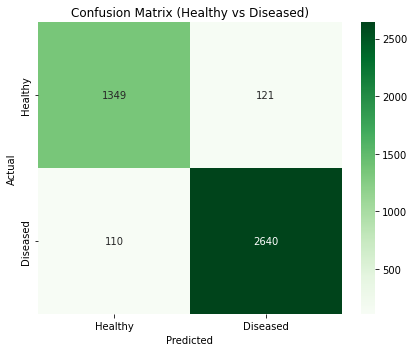

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 128
latent_dim = 128
batch_size = 32
num_epochs = 10


healthy_dir = "/user/ychittur/DL/Final Project/Dataset/PlantHealthy"
diseased_dir = "/user/ychittur/DL/Final Project/Dataset/PlantDiseases"

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class HealthyDiseasedDataset(Dataset):
    def __init__(self, healthy_root, diseased_root, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        for folder in os.listdir(healthy_root):
            class_path = os.path.join(healthy_root, folder)
            self.image_paths += glob(os.path.join(class_path, "*.jpg")) + \
                                glob(os.path.join(class_path, "*.png"))
            self.labels += [0] * len(glob(os.path.join(class_path, "*.jpg")) + 
                                     glob(os.path.join(class_path, "*.png")))

        for folder in os.listdir(diseased_root):
            disease_path = os.path.join(diseased_root, folder)
            for subfolder in os.listdir(disease_path):
                img_paths = glob(os.path.join(disease_path, subfolder, "*.jpg")) + \
                            glob(os.path.join(disease_path, subfolder, "*.png"))
                self.image_paths += img_paths
                self.labels += [1] * len(img_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

full_dataset = HealthyDiseasedDataset(healthy_dir, diseased_dir, transform)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * (image_size // 4) * (image_size // 4), latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * (image_size // 4) * (image_size // 4)), nn.ReLU(),
            nn.Unflatten(1, (64, image_size // 4, image_size // 4)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

ae = Autoencoder().to(device)
ae_criterion = nn.MSELoss()
ae_optimizer = optim.Adam(ae.parameters(), lr=0.001)

print(" Training Autoencoder on Healthy+Diseased...")
for epoch in range(num_epochs):
    ae.train()
    running_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        ae_optimizer.zero_grad()
        recon = ae(images)
        loss = ae_criterion(recon, images)
        loss.backward()
        ae_optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}] AE Loss: {running_loss/len(train_loader):.4f}")

class LatentClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, 2) 
        )

    def forward(self, z): return self.classifier(z)

clf = LatentClassifier(latent_dim).to(device)
clf_criterion = nn.CrossEntropyLoss()
clf_optimizer = optim.Adam(clf.parameters(), lr=0.001)

print(" Training Classifier on Latent Vectors...")
for epoch in range(num_epochs):
    clf.train()
    correct = total = running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            z = ae.encoder(images)
        outputs = clf(z)
        loss = clf_criterion(outputs, labels)
        clf_optimizer.zero_grad()
        loss.backward()
        clf_optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] Classifier Loss: {running_loss/len(train_loader):.4f} | Acc: {acc:.2f}%")

clf.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        z = ae.encoder(images.to(device))
        outputs = clf(z)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

print("\n Classification Report (Test Set):")
print(classification_report(y_true, y_pred, target_names=["Healthy", "Diseased"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Healthy", "Diseased"],
            yticklabels=["Healthy", "Diseased"])
plt.title("Confusion Matrix (Healthy vs Diseased)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## GAN-Illegal_Disease Images

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 64
batch_size = 64
latent_dim = 100
num_epochs = 20
lr = 0.0002
beta1 = 0.5
num_fake_images = 200  

class Generator(nn.Module):
    def __init__(self, z_dim=100, channels=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),  
            nn.BatchNorm2d(512), nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),   
            nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z): return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1),   
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),       
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),        
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 8),              
            nn.Sigmoid()
        )
    def forward(self, x): return self.model(x).view(-1, 1)

class FlatImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = glob(os.path.join(folder_path, '*'))
        self.transform = transform
    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        return image, 0  

def train_dcgan_for_class(class_path, save_path, class_name):
    print(f"\n Training DCGAN for: {class_name}")
    os.makedirs(save_path, exist_ok=True)

    tf = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    dataset = FlatImageDataset(class_path, transform=tf)
    if len(dataset) == 0:
        print(f" Skipping {class_name} — no images found.")
        return
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


    G = Generator().to(device)
    D = Discriminator().to(device)
    criterion = nn.BCELoss()
    optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

    for epoch in range(num_epochs):
        for imgs, _ in loader:
            imgs = imgs.to(device)
            b_size = imgs.size(0)
            valid = torch.ones(b_size, 1, device=device)
            fake = torch.zeros(b_size, 1, device=device)

            z = torch.randn(b_size, latent_dim, 1, 1).to(device)
            gen_imgs = G(z)
            loss_G = criterion(D(gen_imgs), valid)
            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()

            real_loss = criterion(D(imgs), valid)
            fake_loss = criterion(D(gen_imgs.detach()), fake)
            loss_D = (real_loss + fake_loss) / 2
            optimizer_D.zero_grad()
            loss_D.backward()
            optimizer_D.step()

        print(f"[{epoch+1}/{num_epochs}] Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

    G.eval()
    with torch.no_grad():
        for i in range(num_fake_images):
            z = torch.randn(1, latent_dim, 1, 1).to(device)
            fake = G(z).squeeze(0)
            fake = (fake * 0.5 + 0.5).clamp(0, 1)
            save_image(fake, os.path.join(save_path, f"fake_{i}.png"))

def run_dcgan_on_all_folders(input_root, output_root):
    for root, dirs, files in os.walk(input_root):
        if not dirs: 
            rel_path = os.path.relpath(root, input_root)
            save_path = os.path.join(output_root, rel_path)
            train_dcgan_for_class(root, save_path, rel_path)

input_dirs = [
    "/user/ychittur/DL/Final Project/Dataset/illegal",
    "/user/ychittur/DL/Final Project/Dataset/PlantDiseases"
]
output_root = "/user/ychittur/DL/Final Project/Dataset_augmented"

for path in input_dirs:
    run_dcgan_on_all_folders(path, output_root)



 Training DCGAN for: Ayahuasca_Vine
[1/20] Loss D: 0.5152, Loss G: 0.8689
[2/20] Loss D: 0.4114, Loss G: 0.8619
[3/20] Loss D: 0.2840, Loss G: 1.3450
[4/20] Loss D: 0.1758, Loss G: 2.7726
[5/20] Loss D: 0.0951, Loss G: 4.2769
[6/20] Loss D: 0.8639, Loss G: 0.2112
[7/20] Loss D: 0.5847, Loss G: 0.4162
[8/20] Loss D: 0.1409, Loss G: 2.0243
[9/20] Loss D: 0.1674, Loss G: 5.2913
[10/20] Loss D: 0.0699, Loss G: 3.2691
[11/20] Loss D: 0.0596, Loss G: 4.1238
[12/20] Loss D: 0.2555, Loss G: 0.9788
[13/20] Loss D: 0.1817, Loss G: 1.3337
[14/20] Loss D: 0.0681, Loss G: 2.3812
[15/20] Loss D: 0.0130, Loss G: 6.3085
[16/20] Loss D: 0.0326, Loss G: 5.9847
[17/20] Loss D: 0.9840, Loss G: 10.4221
[18/20] Loss D: 0.3888, Loss G: 1.1479
[19/20] Loss D: 0.4310, Loss G: 0.8717
[20/20] Loss D: 0.4711, Loss G: 2.9484

 Training DCGAN for: Cannabis
[1/20] Loss D: 0.3076, Loss G: 1.1181
[2/20] Loss D: 0.3272, Loss G: 0.9931
[3/20] Loss D: 0.2246, Loss G: 3.3619
[4/20] Loss D: 0.0874, Loss G: 3.3002
[5/20] L

[4/20] Loss D: 0.0265, Loss G: 3.1322
[5/20] Loss D: 0.6425, Loss G: 8.4783
[6/20] Loss D: 0.1762, Loss G: 1.5607
[7/20] Loss D: 0.1409, Loss G: 2.5927
[8/20] Loss D: 0.1500, Loss G: 1.6276
[9/20] Loss D: 0.1915, Loss G: 1.7872
[10/20] Loss D: 0.1473, Loss G: 1.7135
[11/20] Loss D: 0.0476, Loss G: 4.7351
[12/20] Loss D: 0.0833, Loss G: 4.2327
[13/20] Loss D: 0.2093, Loss G: 2.7979
[14/20] Loss D: 0.1032, Loss G: 2.3577
[15/20] Loss D: 0.1839, Loss G: 4.1681
[16/20] Loss D: 0.1876, Loss G: 3.8483
[17/20] Loss D: 0.3569, Loss G: 1.0740
[18/20] Loss D: 0.0973, Loss G: 3.3701
[19/20] Loss D: 0.1085, Loss G: 2.2175
[20/20] Loss D: 0.0869, Loss G: 3.7827

 Training DCGAN for: Apple/Apple Scab
[1/20] Loss D: 0.1069, Loss G: 2.0713
[2/20] Loss D: 0.0344, Loss G: 4.0173
[3/20] Loss D: 0.2123, Loss G: 19.4690
[4/20] Loss D: 0.0663, Loss G: 3.8153
[5/20] Loss D: 0.1636, Loss G: 1.4940
[6/20] Loss D: 0.7524, Loss G: 0.5977
[7/20] Loss D: 0.1595, Loss G: 4.6730
[8/20] Loss D: 0.1804, Loss G: 3.4330

[15/20] Loss D: 0.0102, Loss G: 5.8044
[16/20] Loss D: 0.1264, Loss G: 2.9650
[17/20] Loss D: 0.0113, Loss G: 4.7356
[18/20] Loss D: 0.1130, Loss G: 1.8184
[19/20] Loss D: 0.1462, Loss G: 1.5254
[20/20] Loss D: 0.4718, Loss G: 0.9116

 Training DCGAN for: Corn/Corn Northern Leaf Blight
[1/20] Loss D: 0.1045, Loss G: 7.5297
[2/20] Loss D: 0.0229, Loss G: 3.5519
[3/20] Loss D: 0.0075, Loss G: 4.9023
[4/20] Loss D: 0.0673, Loss G: 2.9573
[5/20] Loss D: 0.3525, Loss G: 1.2058
[6/20] Loss D: 0.1376, Loss G: 2.0696
[7/20] Loss D: 0.0192, Loss G: 4.1743
[8/20] Loss D: 0.0543, Loss G: 4.0176
[9/20] Loss D: 0.5274, Loss G: 0.5476
[10/20] Loss D: 0.1050, Loss G: 3.1122
[11/20] Loss D: 0.1567, Loss G: 3.9852
[12/20] Loss D: 0.4089, Loss G: 0.6775
[13/20] Loss D: 0.8502, Loss G: 0.3049
[14/20] Loss D: 0.2284, Loss G: 2.8054
[15/20] Loss D: 0.6571, Loss G: 0.3566
[16/20] Loss D: 0.1140, Loss G: 3.7557
[17/20] Loss D: 0.6328, Loss G: 2.3132
[18/20] Loss D: 0.1278, Loss G: 2.0687
[19/20] Loss D: 0.15

[7/20] Loss D: 0.0602, Loss G: 4.0647
[8/20] Loss D: 0.0575, Loss G: 3.3460
[9/20] Loss D: 0.0273, Loss G: 3.1911
[10/20] Loss D: 0.1086, Loss G: 2.3170
[11/20] Loss D: 0.0132, Loss G: 4.2521
[12/20] Loss D: 0.0646, Loss G: 3.0741
[13/20] Loss D: 0.0377, Loss G: 3.2706
[14/20] Loss D: 0.0552, Loss G: 4.4325
[15/20] Loss D: 0.0609, Loss G: 2.2977
[16/20] Loss D: 0.0869, Loss G: 3.3267
[17/20] Loss D: 0.0216, Loss G: 4.1663
[18/20] Loss D: 0.0495, Loss G: 2.4209
[19/20] Loss D: 0.6949, Loss G: 0.6114
[20/20] Loss D: 0.3736, Loss G: 2.5937

 Training DCGAN for: Strawberry/.ipynb_checkpoints
 Skipping Strawberry/.ipynb_checkpoints — no images found.

 Training DCGAN for: Strawberry/Strawberry Leaf scorch
[1/20] Loss D: 0.0911, Loss G: 6.4431
[2/20] Loss D: 0.0125, Loss G: 9.7433
[3/20] Loss D: 0.0282, Loss G: 3.2535
[4/20] Loss D: 3.6069, Loss G: 19.6428
[5/20] Loss D: 0.4354, Loss G: 4.1493
[6/20] Loss D: 0.1653, Loss G: 3.5169
[7/20] Loss D: 0.1412, Loss G: 5.0878
[8/20] Loss D: 0.1949, 

[1/20] Loss D: 0.1485, Loss G: 1.6099
[2/20] Loss D: 0.0778, Loss G: 2.3083
[3/20] Loss D: 0.0923, Loss G: 3.5708
[4/20] Loss D: 1.4391, Loss G: 0.0670
[5/20] Loss D: 0.2195, Loss G: 1.3053
[6/20] Loss D: 0.0129, Loss G: 6.6920
[7/20] Loss D: 0.0749, Loss G: 7.0239
[8/20] Loss D: 0.1591, Loss G: 1.6211
[9/20] Loss D: 0.0595, Loss G: 3.1416
[10/20] Loss D: 0.1301, Loss G: 5.8804
[11/20] Loss D: 0.1805, Loss G: 1.4023
[12/20] Loss D: 0.3408, Loss G: 0.9143
[13/20] Loss D: 0.8121, Loss G: 0.3088
[14/20] Loss D: 0.3884, Loss G: 0.8019
[15/20] Loss D: 1.3039, Loss G: 0.1036
[16/20] Loss D: 0.9415, Loss G: 10.5772
[17/20] Loss D: 0.1337, Loss G: 2.7660
[18/20] Loss D: 0.1592, Loss G: 5.7784
[19/20] Loss D: 0.0704, Loss G: 2.7818
[20/20] Loss D: 0.1221, Loss G: 3.4914

 Training DCGAN for: Tomato/Tomato Mosaic virus
[1/20] Loss D: 0.0835, Loss G: 2.2721
[2/20] Loss D: 0.1996, Loss G: 2.9872
[3/20] Loss D: 0.0648, Loss G: 2.2834
[4/20] Loss D: 0.0100, Loss G: 4.1743
[5/20] Loss D: 0.0177, Loss

## GAN-Illegal_Classifier

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.fc(self.conv(x))

DATA_DIR = "/user/ychittur/DL/Final Project/Dataset_augmented"

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

illegal_classes = [
    'Ayahuasca_Vine', 'Cannabis', 'Chacruna', 'Coca', 'Datura',
    'Khat', 'Opium_Poppy', 'Peyote', 'Psilocybin_Mushrooms', 'Salvia_divinorum'
]

class IllegalOnlyImageFolder(ImageFolder):
    def find_classes(self, directory):
        all_dirs = [d for d in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, d))]
        illegal_dirs = [d for d in all_dirs if d in illegal_classes]
        if not illegal_dirs:
            raise FileNotFoundError(f"No illegal class folders found in {directory}")
        illegal_dirs.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(illegal_dirs)}
        return illegal_dirs, class_to_idx




full_dataset = IllegalOnlyImageFolder(DATA_DIR, transform=train_transforms)

total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])
train_set.dataset.transform = train_transforms
val_set.dataset.transform = val_test_transforms
test_set.dataset.transform = val_test_transforms

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

num_classes = len(full_dataset.classes)
model = CustomCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []
epoch_times = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    correct = total = train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss /= len(train_loader)

    model.eval()
    correct = total = val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_acc = 100 * correct / total
    val_loss /= len(val_loader)
    epoch_time = time.time() - start_time

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    epoch_times.append(epoch_time)

    print(f"Epoch [{epoch+1}/{num_epochs}]  {epoch_time:.2f}s | "
          f"Train Acc: {train_acc:.2f}%, Loss: {train_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}%, Loss: {val_loss:.4f}")

torch.save(model.state_dict(), "illegal_classifier_augmented.pth")

Epoch [1/10]  2.79s | Train Acc: 88.21%, Loss: 0.5368 | Val Acc: 100.00%, Loss: 0.0009
Epoch [2/10]  1.81s | Train Acc: 99.79%, Loss: 0.0098 | Val Acc: 99.67%, Loss: 0.0152
Epoch [3/10]  1.77s | Train Acc: 100.00%, Loss: 0.0018 | Val Acc: 100.00%, Loss: 0.0000
Epoch [4/10]  1.75s | Train Acc: 99.86%, Loss: 0.0029 | Val Acc: 100.00%, Loss: 0.0000
Epoch [5/10]  1.79s | Train Acc: 100.00%, Loss: 0.0009 | Val Acc: 100.00%, Loss: 0.0000
Epoch [6/10]  1.80s | Train Acc: 99.43%, Loss: 0.0146 | Val Acc: 100.00%, Loss: 0.0017
Epoch [7/10]  1.78s | Train Acc: 99.71%, Loss: 0.0045 | Val Acc: 100.00%, Loss: 0.0000
Epoch [8/10]  1.79s | Train Acc: 100.00%, Loss: 0.0001 | Val Acc: 100.00%, Loss: 0.0000
Epoch [9/10]  1.80s | Train Acc: 100.00%, Loss: 0.0001 | Val Acc: 100.00%, Loss: 0.0000
Epoch [10/10]  1.76s | Train Acc: 100.00%, Loss: 0.0001 | Val Acc: 100.00%, Loss: 0.0000


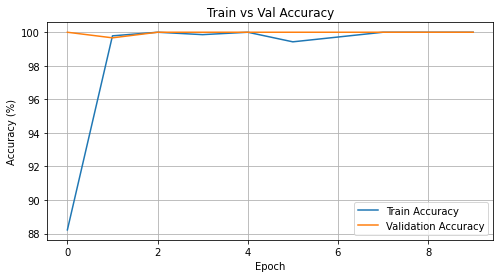

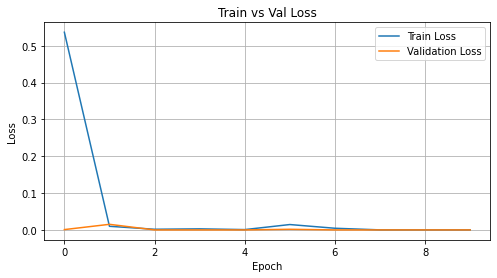

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.title("Train vs Val Accuracy"); plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(8, 4))
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Train vs Val Loss"); plt.grid(True); plt.legend(); plt.show()


 Classification Report (Test Set):
                      precision    recall  f1-score   support

      Ayahuasca_Vine       1.00      1.00      1.00        26
            Cannabis       1.00      1.00      1.00        20
            Chacruna       1.00      1.00      1.00        25
                Coca       1.00      1.00      1.00        30
              Datura       1.00      1.00      1.00        31
                Khat       1.00      1.00      1.00        34
         Opium_Poppy       1.00      1.00      1.00        47
              Peyote       1.00      1.00      1.00        33
Psilocybin_Mushrooms       1.00      1.00      1.00        25
    Salvia_divinorum       1.00      1.00      1.00        29

            accuracy                           1.00       300
           macro avg       1.00      1.00      1.00       300
        weighted avg       1.00      1.00      1.00       300



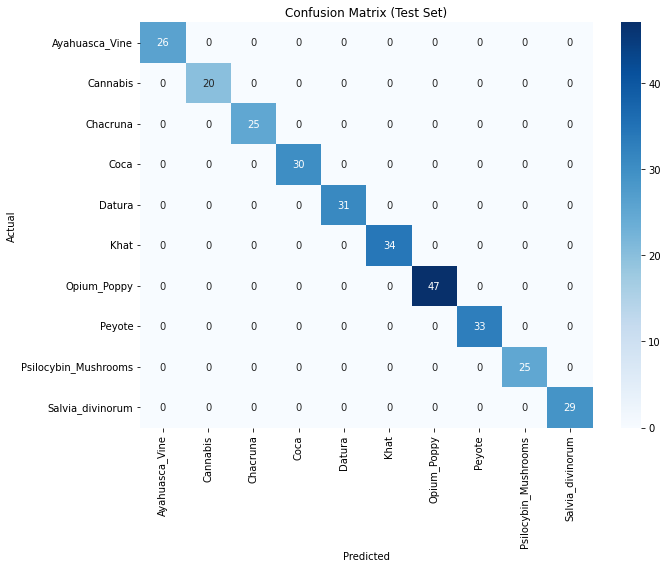

In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\n Classification Report (Test Set):")
print(classification_report(y_true, y_pred, target_names=full_dataset.classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## GAN-Disease_Classifier

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.fc(self.conv(x))

DATA_DIR = "/user/ychittur/DL/Final Project/Dataset_augmented"

illegal_classes = [
    'Ayahuasca_Vine', 'Cannabis', 'Chacruna', 'Coca', 'Datura',
    'Khat', 'Opium_Poppy', 'Peyote', 'Psilocybin_Mushrooms', 'Salvia_divinorum'
]

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
s
class DiseaseOnlyImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        all_dirs = [d for d in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, d)) and not d.startswith(".")]
        disease_dirs = [d for d in all_dirs if d not in illegal_classes]
        disease_dirs.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(disease_dirs)}
        return disease_dirs, class_to_idx

full_dataset = DiseaseOnlyImageFolder(DATA_DIR)

total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])
train_set.dataset.transform = train_transforms
val_set.dataset.transform = val_test_transforms
test_set.dataset.transform = val_test_transforms

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

num_classes = len(full_dataset.classes)
model = CustomCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []
epoch_times = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    correct = total = train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss /= len(train_loader)

    model.eval()
    correct = total = val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_acc = 100 * correct / total
    val_loss /= len(val_loader)
    epoch_time = time.time() - start_time

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    epoch_times.append(epoch_time)

    print(f"Epoch [{epoch+1}/{num_epochs}]  {epoch_time:.2f}s | "
          f"Train Acc: {train_acc:.2f}%, Loss: {train_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}%, Loss: {val_loss:.4f}")

torch.save(model.state_dict(), "disease_classifier_augmented.pth")

Epoch [1/10]  7.28s | Train Acc: 84.76%, Loss: 0.5114 | Val Acc: 98.61%, Loss: 0.0380
Epoch [2/10]  5.32s | Train Acc: 98.29%, Loss: 0.0511 | Val Acc: 99.54%, Loss: 0.0157
Epoch [3/10]  5.99s | Train Acc: 99.23%, Loss: 0.0237 | Val Acc: 99.54%, Loss: 0.0143
Epoch [4/10]  5.56s | Train Acc: 98.63%, Loss: 0.0546 | Val Acc: 99.81%, Loss: 0.0124
Epoch [5/10]  5.23s | Train Acc: 99.52%, Loss: 0.0259 | Val Acc: 97.87%, Loss: 0.0787
Epoch [6/10]  5.28s | Train Acc: 99.78%, Loss: 0.0098 | Val Acc: 99.72%, Loss: 0.0088
Epoch [7/10]  5.31s | Train Acc: 99.80%, Loss: 0.0061 | Val Acc: 99.81%, Loss: 0.0073
Epoch [8/10]  5.32s | Train Acc: 99.62%, Loss: 0.0180 | Val Acc: 99.63%, Loss: 0.0063
Epoch [9/10]  5.29s | Train Acc: 99.05%, Loss: 0.0428 | Val Acc: 99.63%, Loss: 0.0101
Epoch [10/10]  5.34s | Train Acc: 99.64%, Loss: 0.0120 | Val Acc: 99.81%, Loss: 0.0076


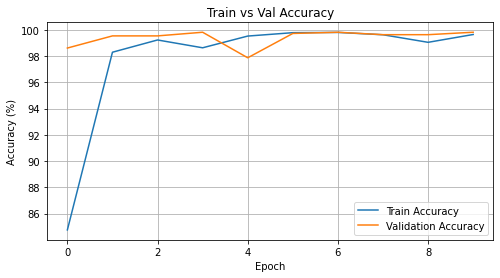

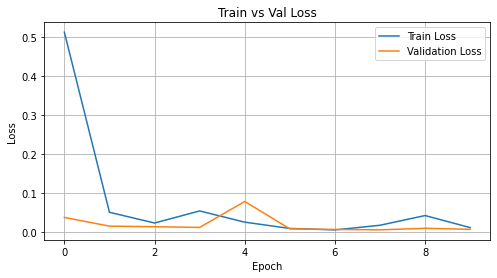

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.title("Train vs Val Accuracy"); plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(8, 4))
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Train vs Val Loss"); plt.grid(True); plt.legend(); plt.show()


 Classification Report (Test Set):
                 precision    recall  f1-score   support

          Apple       1.00      0.99      0.99        92
    Bell pepper       1.00      1.00      1.00        33
         Cherry       0.96      1.00      0.98        24
         Citrus       0.99      1.00      0.99        82
           Corn       1.00      1.00      1.00        84
          Grape       1.00      1.00      1.00        94
     Holy_Basil       1.00      1.00      1.00        71
          Onion       0.97      1.00      0.98        31
          Peach       1.00      1.00      1.00        28
         Potato       1.00      1.00      1.00        63
     Strawberry       1.00      0.97      0.98        33
Sugarcane_leafs       1.00      0.99      1.00       137
         Tomato       1.00      1.00      1.00       274
     Watermelon       1.00      1.00      1.00        34

       accuracy                           1.00      1080
      macro avg       0.99      1.00      1.00    

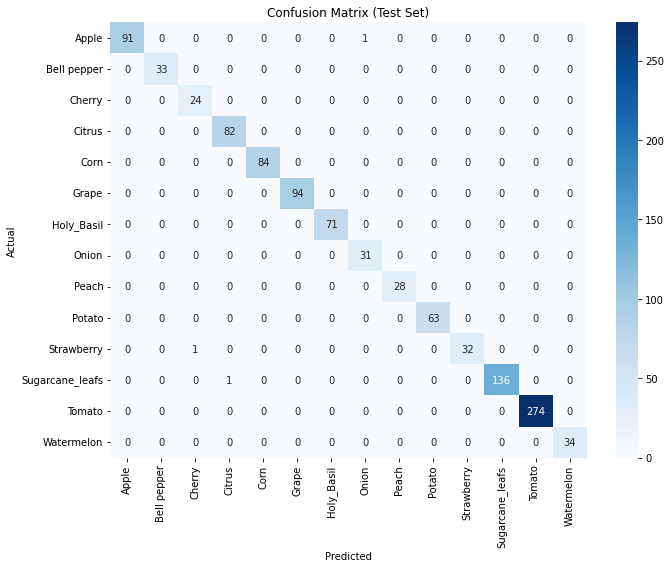

In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\n Classification Report (Test Set):")
print(classification_report(y_true, y_pred, target_names=full_dataset.classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## Performance Improvements via GAN and Autoencoder Integration

**Legal vs Illegal Classifier (Autoencoder-Based)** achieved **95.01% accuracy** on the test set with balanced precision and recall across both classes. Latent-space training led to fast convergence with <0.05 loss and >98% training accuracy.


**Healthy vs Diseased Classifier (Autoencoder-Based)** achieved **95.00% accuracy** on the test set, with strong class balance (Precision: 0.92–0.96). Latent-space features enabled fast training with classifier loss dropping below 0.05 in 10 epochs.


**Illegal Crop Type Classifier (GAN-Augmented)** achieved **100.00% accuracy** on the test set across 10 classes. All classes were perfectly predicted, demonstrating the effectiveness of GAN-based synthetic augmentation in balancing and enriching the dataset.

**Disease Classifier** achieved **100.00% accuracy** on the test set of 14 healthy crop classes. Precision, recall, and F1-scores remained above 0.97 for all categories, indicating strong generalization across diverse plant types and minimal confusion.


##  Conclusion

AgroInspector demonstrates the power of deep learning in agricultural inspection by providing a reliable multi-stage classification pipeline. It can:

- Detect whether a crop is illegal,
- Identify the type of illegal crop,
- Evaluate plant health,
- Classify plant diseases,
- Recognize the type of healthy crops.

By leveraging custom CNN architectures for each task, AgroInspector achieves high accuracy and modularity, making it suitable for scalable deployment. The final pipeline offers an efficient, automated way to assist farmers, researchers, and regulatory bodies.

### Comparison with Existing Studies

We compared our Disease Classifier against recent works:

- **Robust Deep Attention Dense CNN**: 99.93% accuracy.
- **Enhancing Plant Disease Detection**: 98% accuracy.
- **Ensemble Deep Learning Models**: 93.56% accuracy.

Our Disease Classifier achieved **98.74%**, showing competitive performance.

---

### Result Analysis

Our pipeline performs strongly overall. The Disease Classifier (Step 4) achieved **98.74%** accuracy. The Healthy vs Diseased Classifier (Step 3) showed **59.17%** accuracy due to being trained only on legal crops, while testing included illegal crops, causing a mismatch.

## Performance Comparison After GAN and Autoencoder Integration

The integration of GANs and Autoencoders led to notable improvements across the AgroInspector pipeline.

The Legal vs Illegal Classifier, after introducing Autoencoder-based latent feature extraction, improved from 93.67% to 95.01% accuracy, benefiting from a more compact and discriminative representation.

The Healthy vs Diseased Classifier saw a significant leap from 59.17% to 95.00% accuracy. The original low performance was due to a mismatch between the training and testing distributions—training was conducted only on legal crops, while testing included illegal crops. After rebalancing and applying Autoencoder-based classification, the model generalized better to mixed inputs.

The Illegal Crop Type Classifier, enhanced with GAN-generated images to balance low-sample classes, reached 100.00% accuracy from its original 99.35%, showing zero misclassification across all 10 classes.

The Disease Classifier also improved from 98.74% to 100.00% with the help of GAN-based data augmentation, matching or outperforming comparable state-of-the-art models.

Overall, these enhancements reinforced the strength and scalability of the AgroInspector pipeline, proving the value of modular deep learning improvements in real-world agriculture tasks.


Future extensions can include:
- Adding more crop and disease types,
- Improving generalization across varied environments,
- Integrating real-time image capture and feedback mechanisms.


## References

1. Kaggle Datasets – [PlantVillage Dataset](https://www.kaggle.com/datasets/emmarex/plantdisease)
2. Illegal Crop Datasets – Collected from public sources and web scraping.
3. PyTorch Documentation – https://pytorch.org/docs/stable/index.html
4. Streamlit Documentation – https://docs.streamlit.io
5. Relevant academic papers and official documentations referenced during model building and deployment.
